# Q学習とSARSA法でCartPoleを学習する

In [1]:
# ref: http://neuro-educator.com/rl1/
# ref: https://qiita.com/sugulu/items/7a14117bbd3d926eb1f2

In [2]:
import gym
import numpy as np
import pandas as pd
from collections import deque 

import utils.display as disp
import utils.learning as learn

In [3]:
class QLearning:
    def __init__(self, num_state, num_action, alpha=0.2, gamma=0.99):
        self.q_table = np.zeros(shape=(num_state, num_action))
        #self.q_table = np.random.uniform(low=-1, high=1, size=(num_state, num_action))
        self.alpha = alpha # 学習率
        self.gamma = gamma# 時間割引率
    
    def get_action(self, state, episode):
         # ε-グリーディ法で行動を選択
        epsilon = 0.5 * (1 / (episode + 1))
        if epsilon <= np.random.uniform(0, 1):
            action = np.argmax(self.q_table[state])
        else:
            action = np.random.choice([0, 1])
        return action
    
    # Q学習
    # Q値が最も高い次の行動で　Q値を更新する
    def update_q_table(self, action, state, next_state, reward):
        # 行動後の最大Q値
        next_max_q_value = max(self.q_table[next_state])
        # 行動前の最大Q値
        q_value = self.q_table[state][action]
        # Q値を更新
        self.q_table[state][action]= (1 - self.alpha) * q_value + self.alpha * (reward + self.gamma * next_max_q_value)
        
    # SARSA法
    # 実際に実行した次のアクションで　Q値を更新する
    def update_q_table_sarsa(self, action, next_action, state, next_state, reward):
        # 行動後の最大Q値
        next_max_q_value = self.q_table[next_state][next_action]
        # 行動前の最大Q値
        q_value = self.q_table[state][action]
        # Q値を更新
        self.q_table[state][action]= (1 - self.alpha) * q_value + self.alpha * (reward + self.gamma * next_max_q_value)

In [4]:
env = gym.make('CartPole-v0')
observation = env.reset()

num_max_episode = 5000 # 学習に使用するエピソード回数
num_max_step = 200 # 1エピソードのステップ数
num_action = 2 # アクション数
num_dizitized = 10 # observationを離散値にする際の分割数
num_state = num_dizitized ** observation.shape[0]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


## Q学習で訓練

In [5]:
learning = QLearning(num_state, num_action)
observation = env.reset()

rewards = []
for episode in range(num_max_episode):
    total_reward = 0
    observation = env.reset()
    
    for step in range(num_max_step):
        state = learn.digitize_state(env, observation, num_dizitized)
        action = learning.get_action(state, episode)
        next_observation, reward, done, info =  env.step(action)
        if done:
            if step < num_max_step-5:
                reward = -200
            else:
                reward = 1
        next_state = learn.digitize_state(env, next_observation, num_dizitized)
        learning.update_q_table(action, state, next_state, reward)
        total_reward += reward
        observation = next_observation
        if done:
            if episode % 100 == 0:
                print('episode: {}, total_reward: {}'.format(episode, total_reward))
            rewards.append(total_reward)
            break

episode: 0, total_reward: -188.0
episode: 100, total_reward: 200.0
episode: 200, total_reward: -65.0
episode: 300, total_reward: -72.0
episode: 400, total_reward: 200.0
episode: 500, total_reward: 200.0
episode: 600, total_reward: 200.0
episode: 700, total_reward: -55.0
episode: 800, total_reward: 200.0
episode: 900, total_reward: 200.0
episode: 1000, total_reward: 200.0
episode: 1100, total_reward: 200.0
episode: 1200, total_reward: 200.0
episode: 1300, total_reward: 200.0
episode: 1400, total_reward: 200.0
episode: 1500, total_reward: 200.0
episode: 1600, total_reward: 200.0
episode: 1700, total_reward: 200.0
episode: 1800, total_reward: 200.0
episode: 1900, total_reward: 200.0
episode: 2000, total_reward: 200.0
episode: 2100, total_reward: 200.0
episode: 2200, total_reward: 200.0
episode: 2300, total_reward: 200.0
episode: 2400, total_reward: 200.0
episode: 2500, total_reward: 200.0
episode: 2600, total_reward: 200.0
episode: 2700, total_reward: 200.0
episode: 2800, total_reward: 20

### 学習後のQ値でシュミレーション


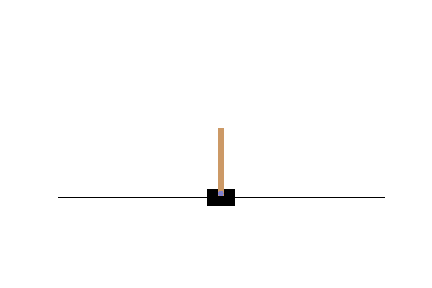
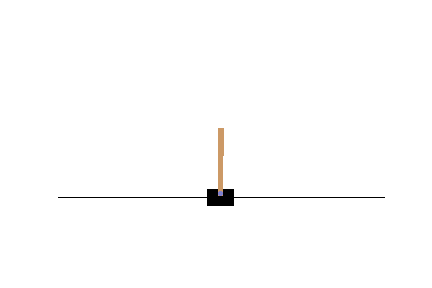
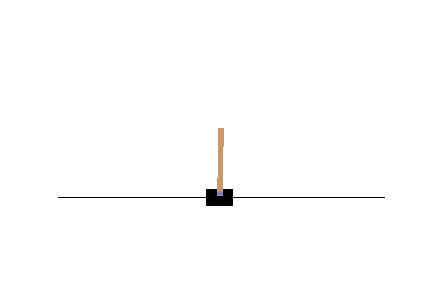
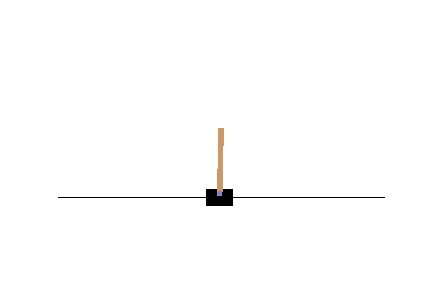
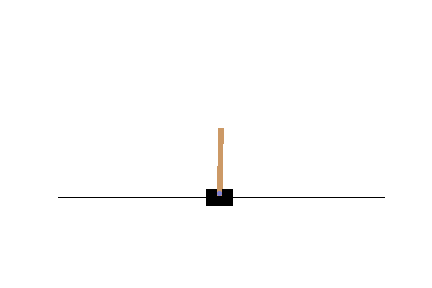
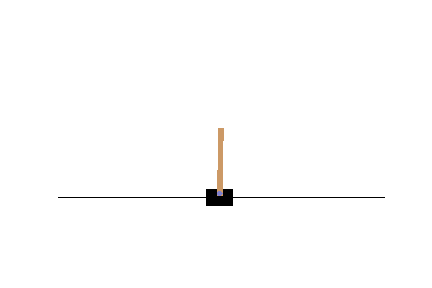
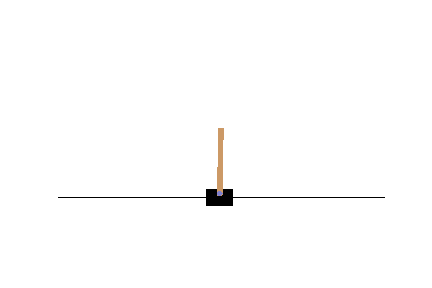
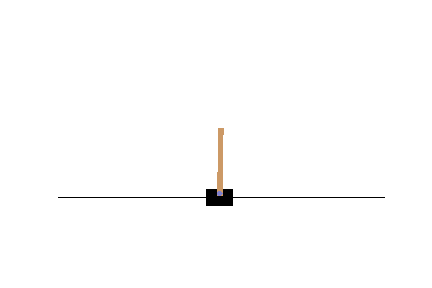
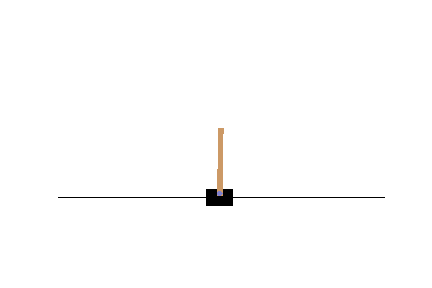
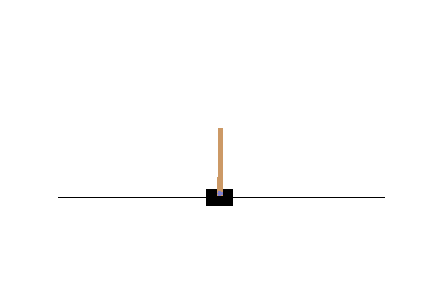
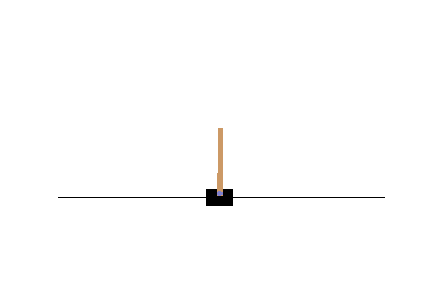
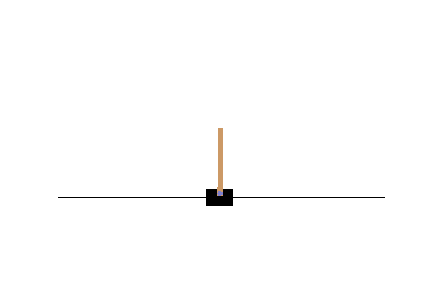
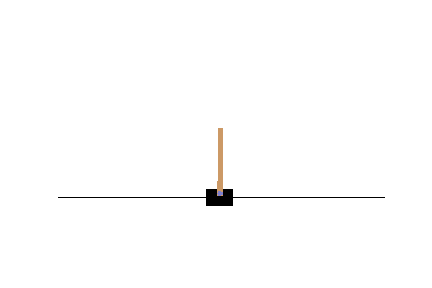
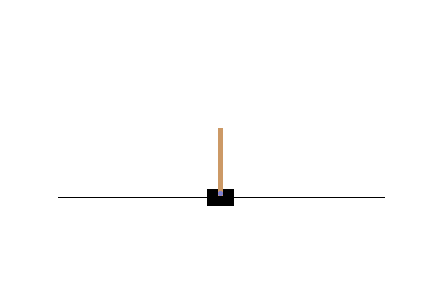
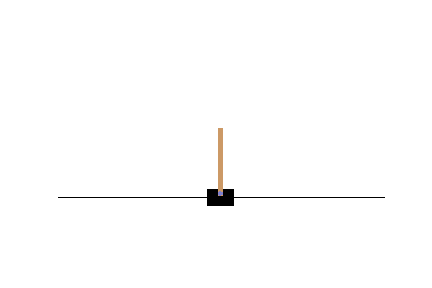
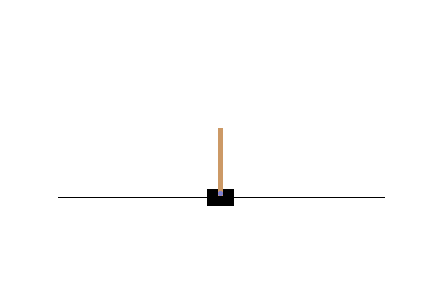
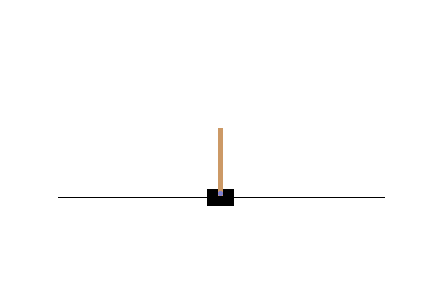
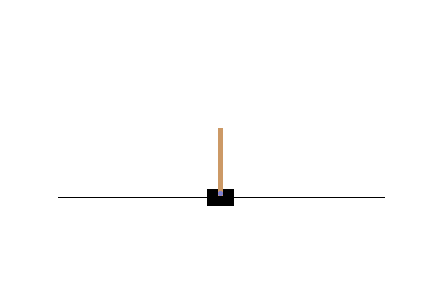
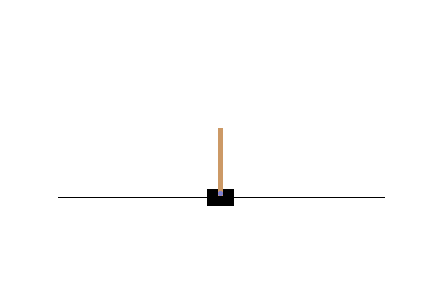
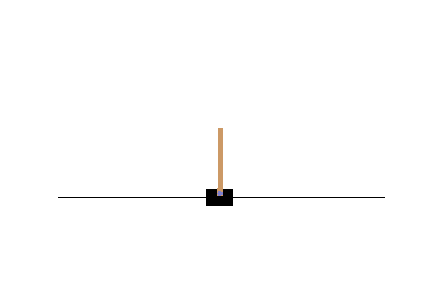
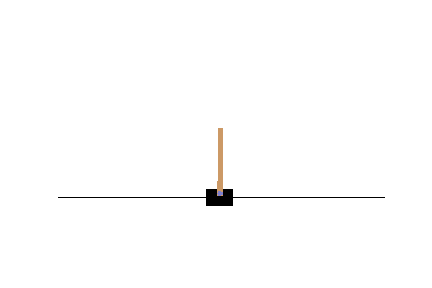
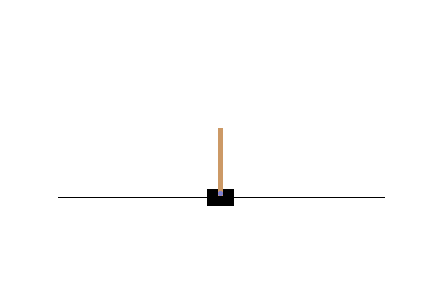
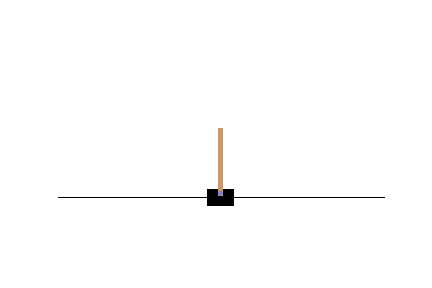
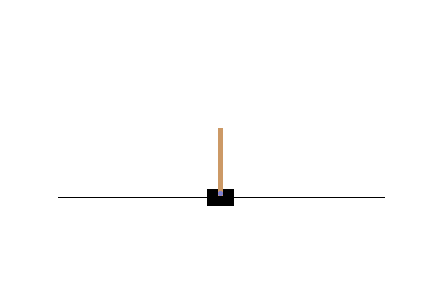
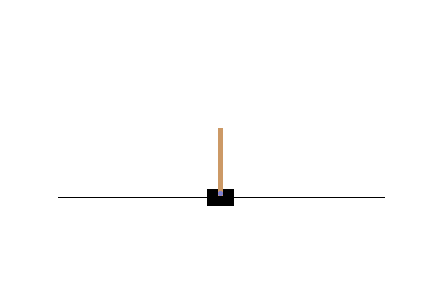
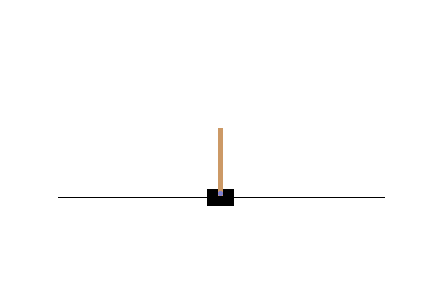
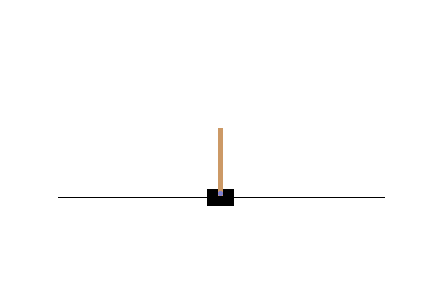
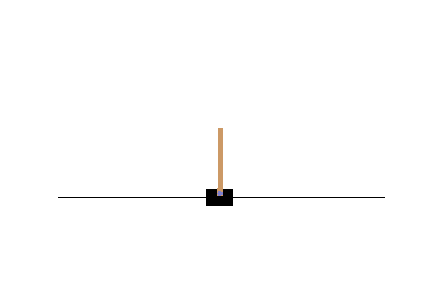
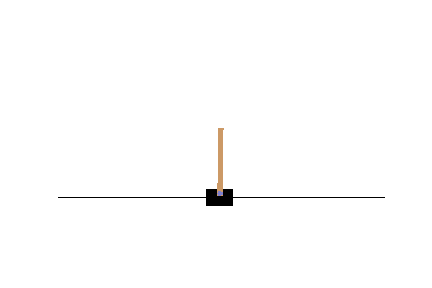
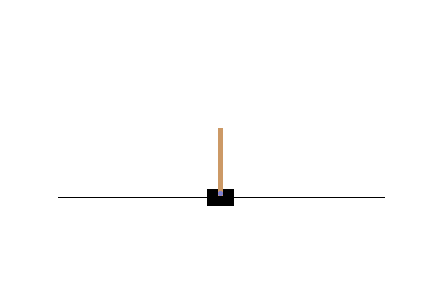
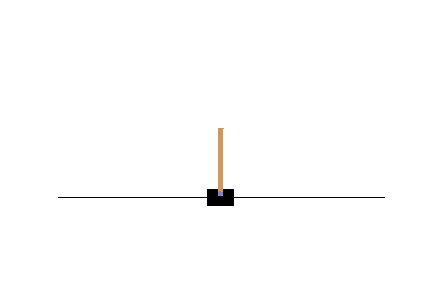
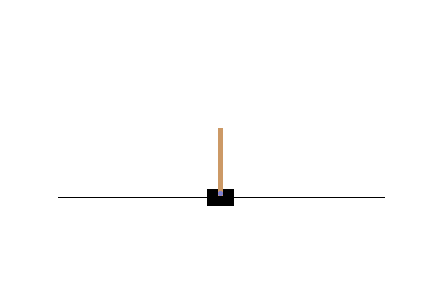
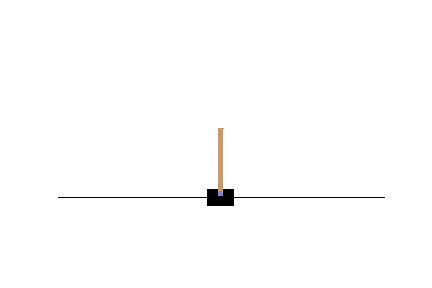
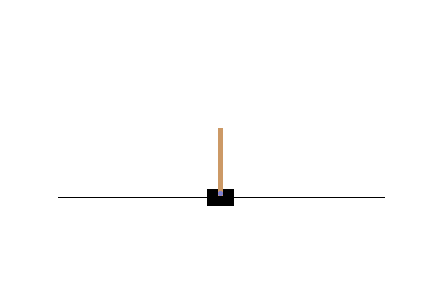
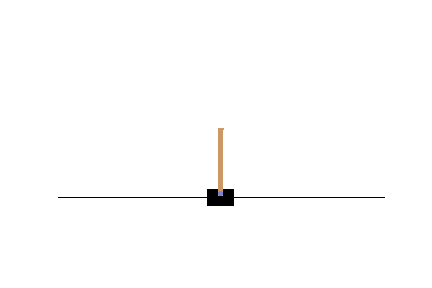
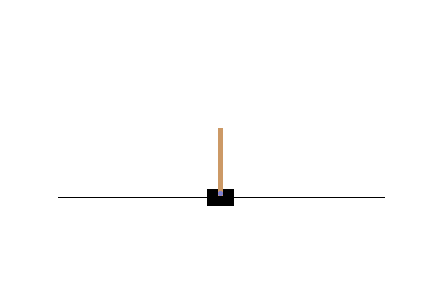
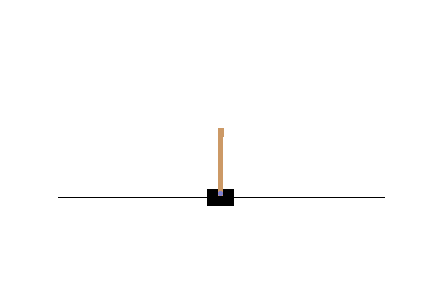
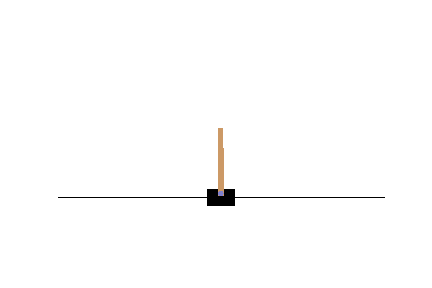
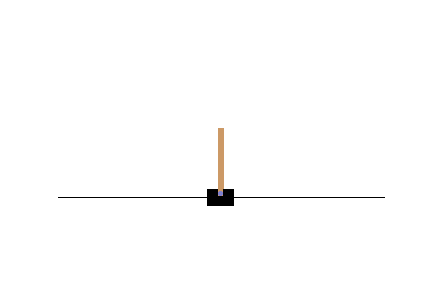
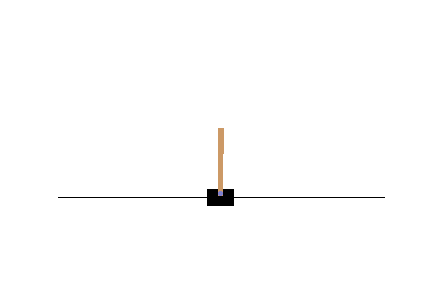
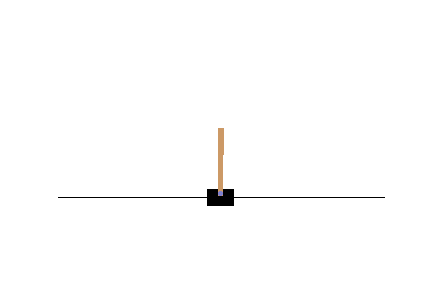
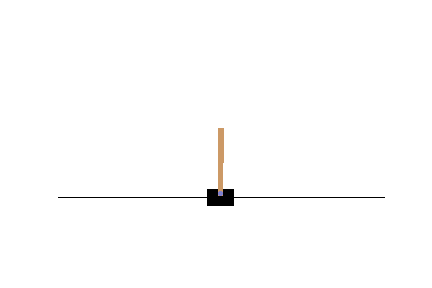
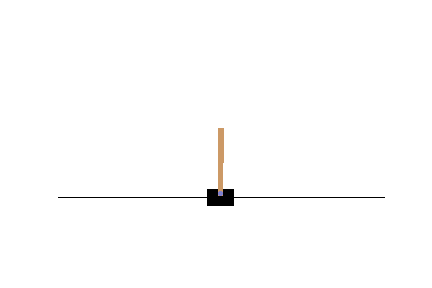
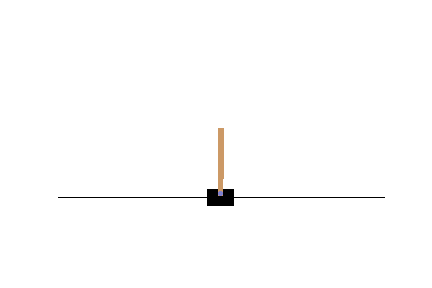
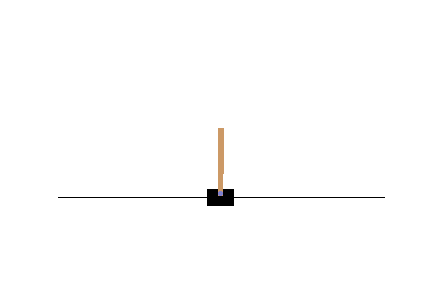
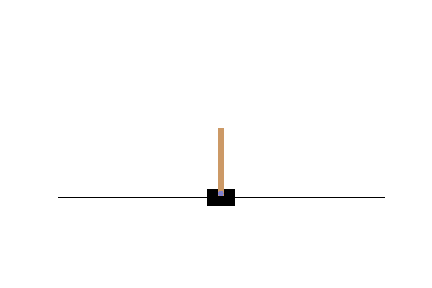
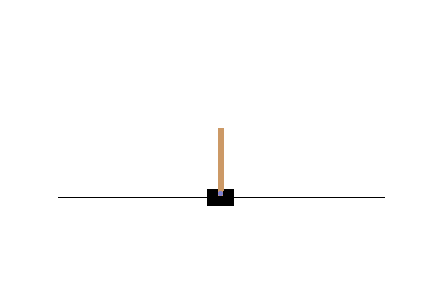
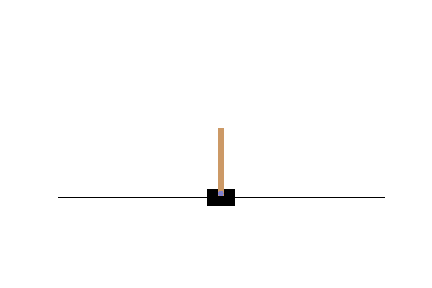
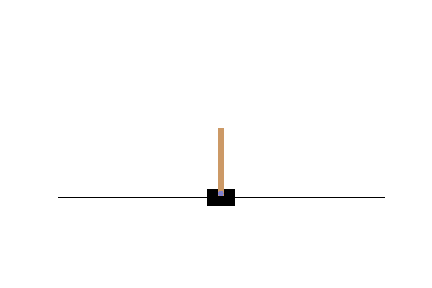
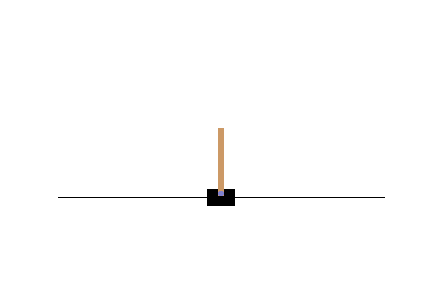
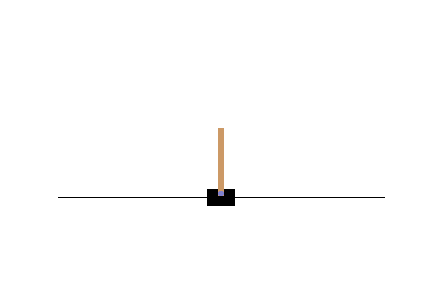
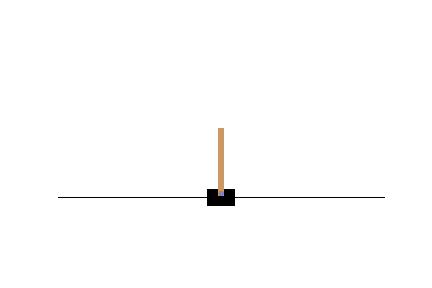
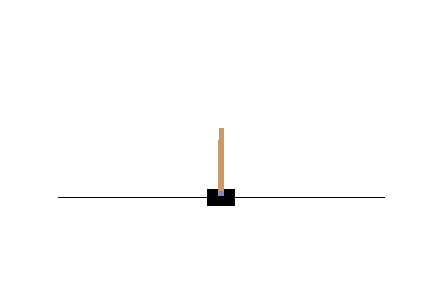
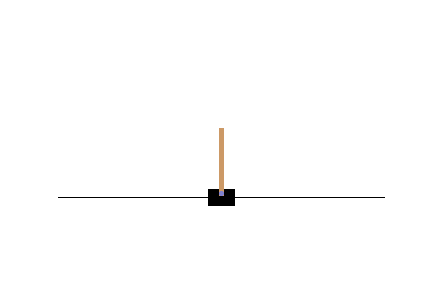
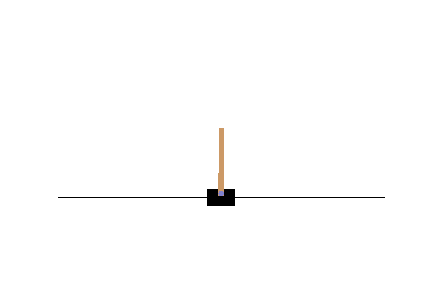
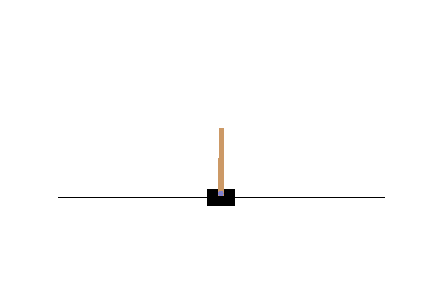
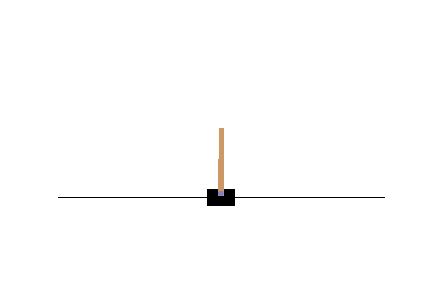
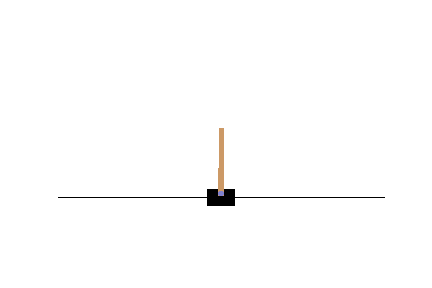
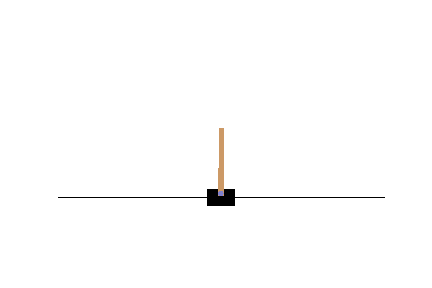
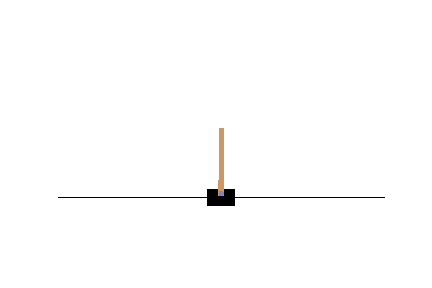
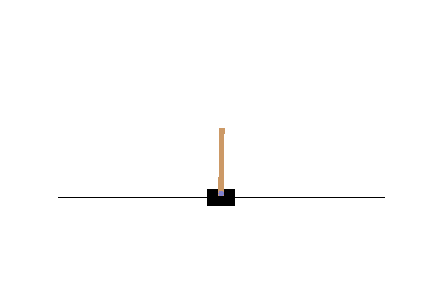
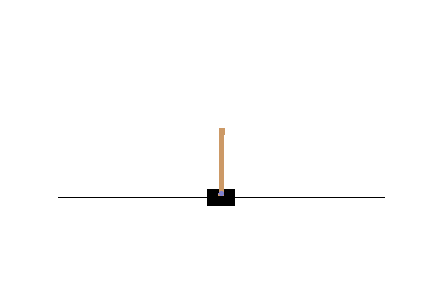
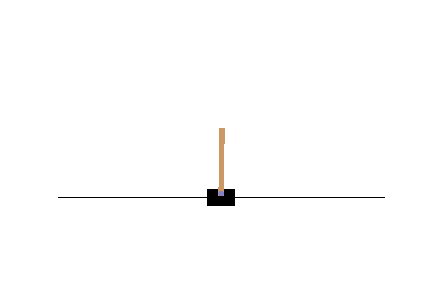
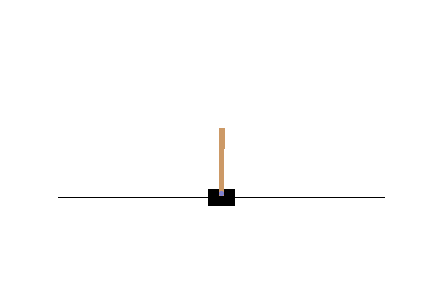
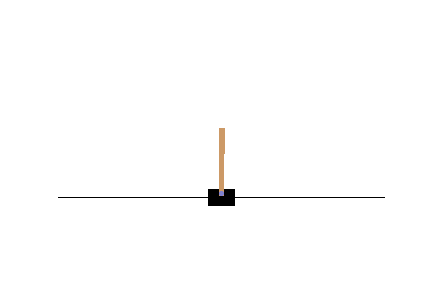
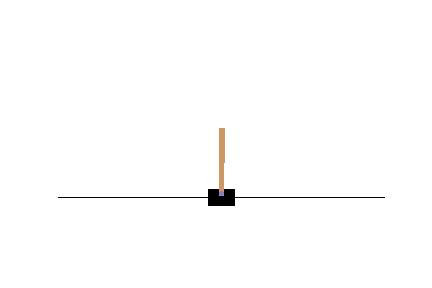
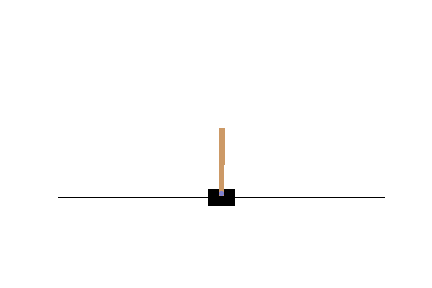
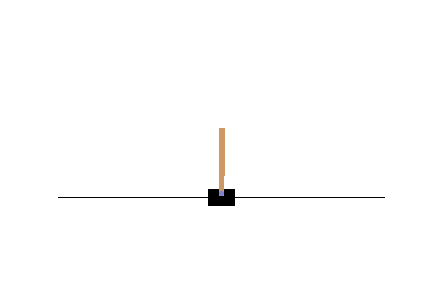
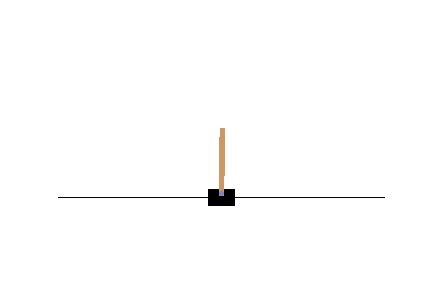
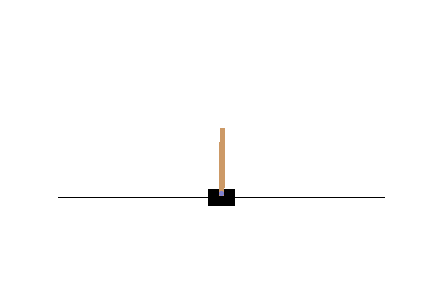
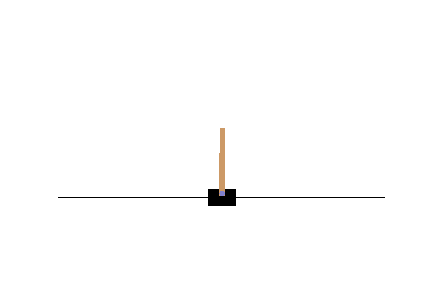
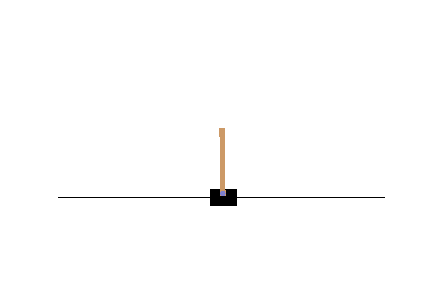
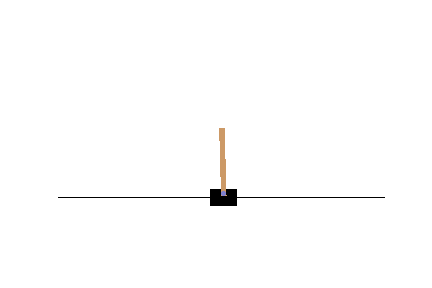
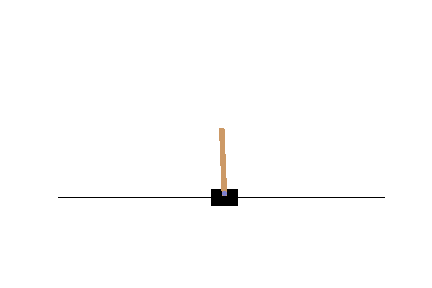
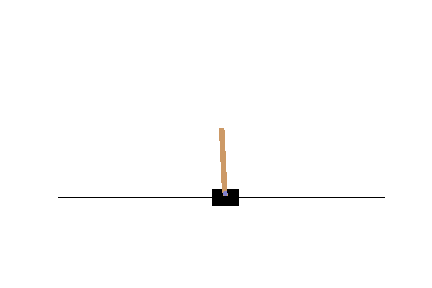
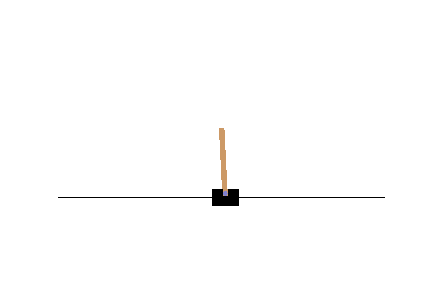
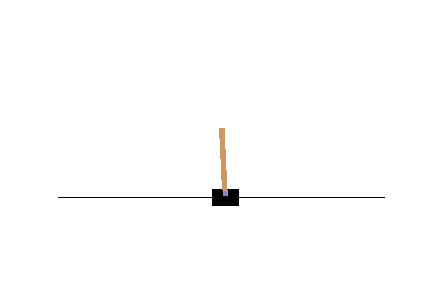
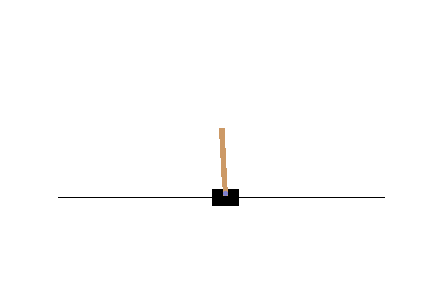
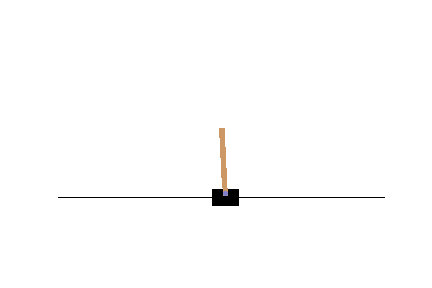
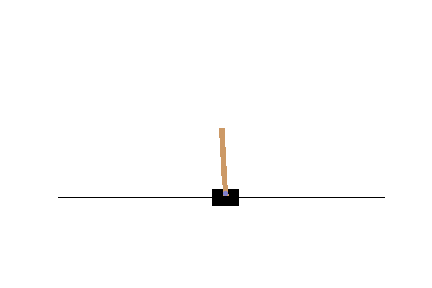
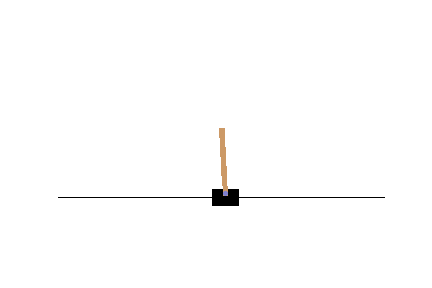
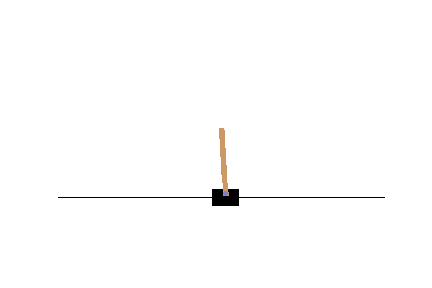
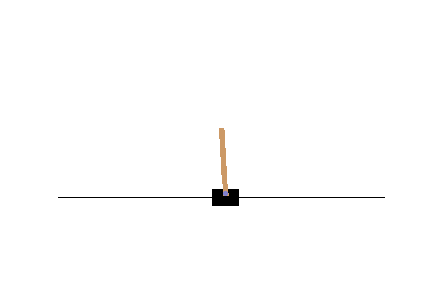
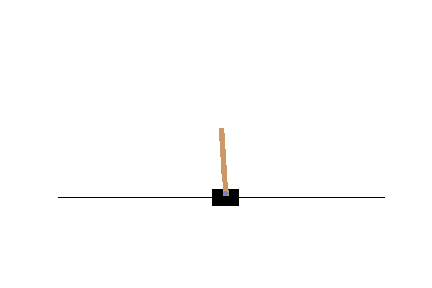
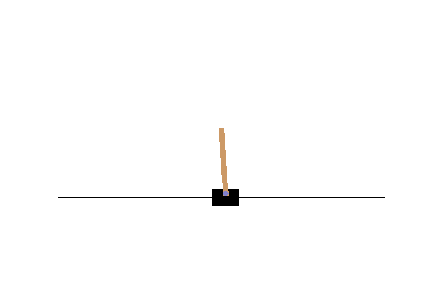
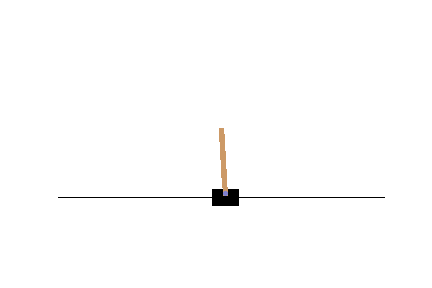
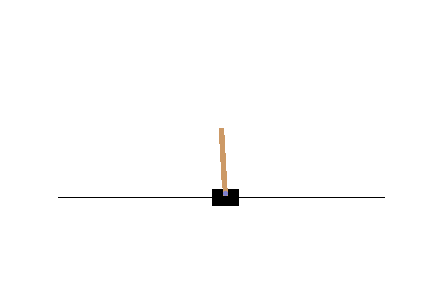
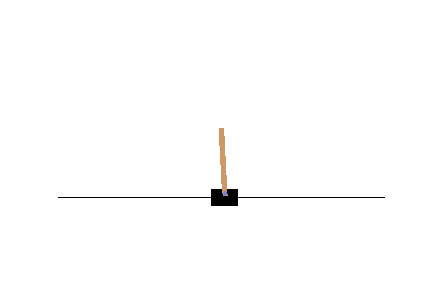
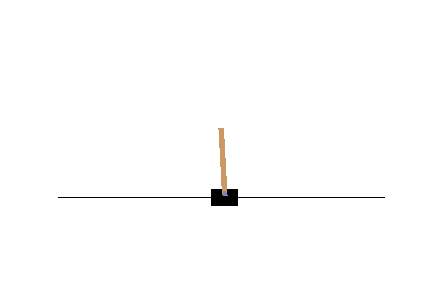
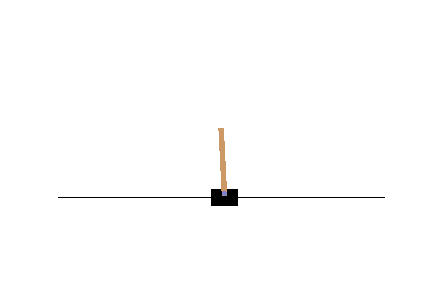
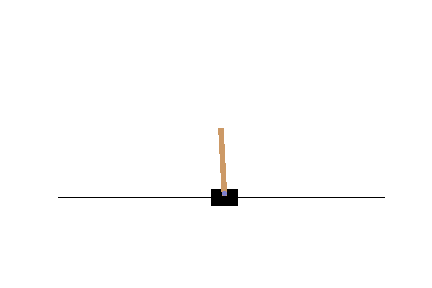
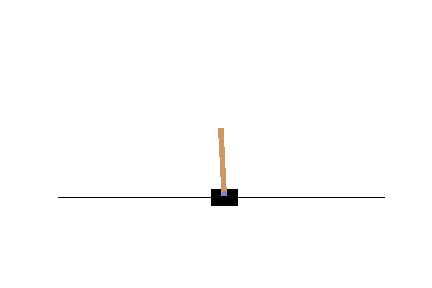
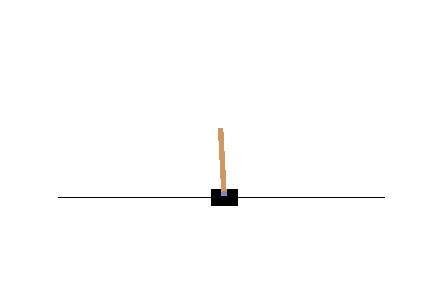
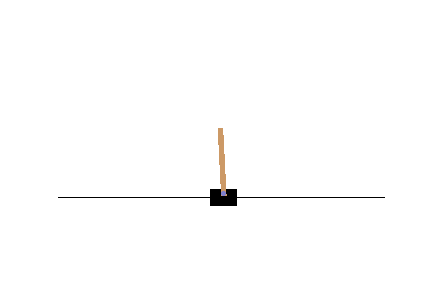
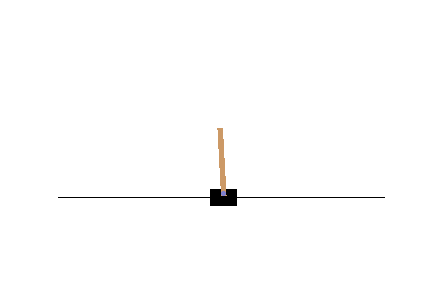
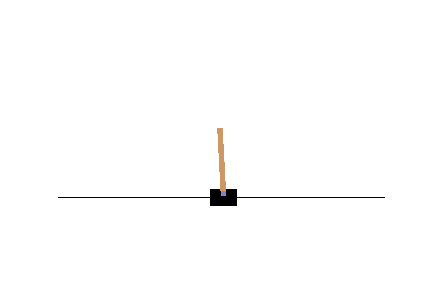
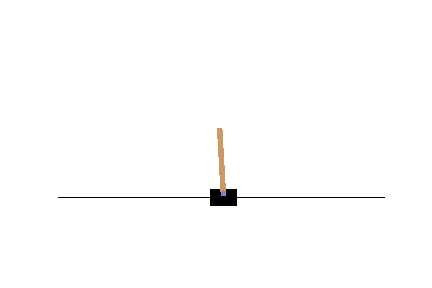
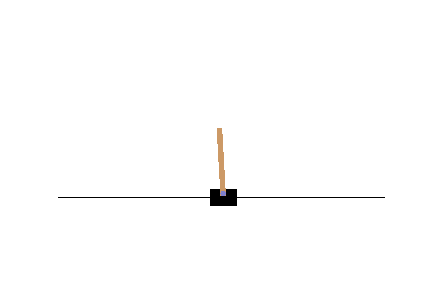
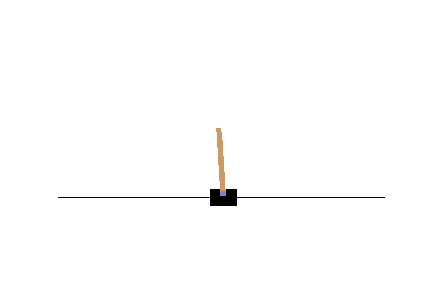
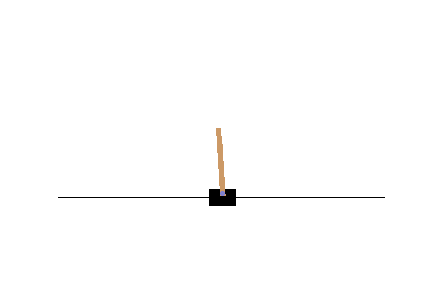
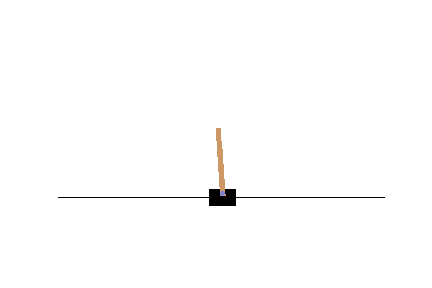
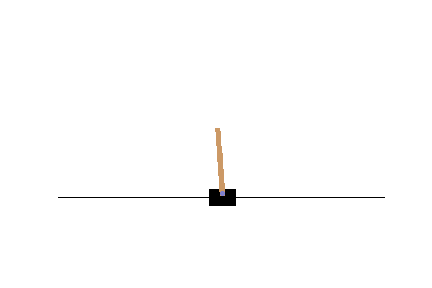
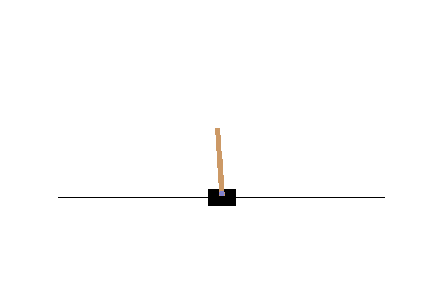
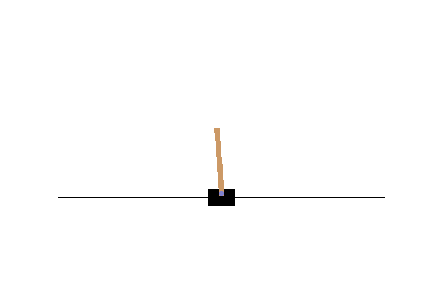
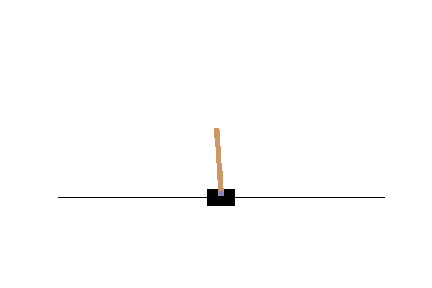
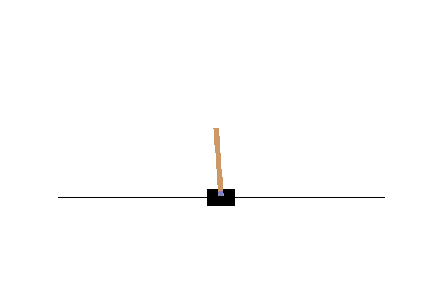
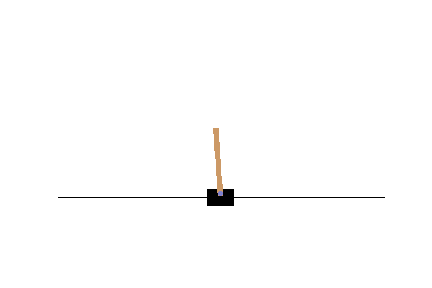
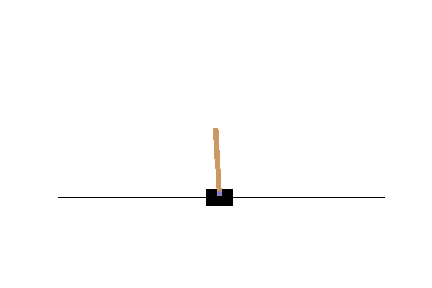
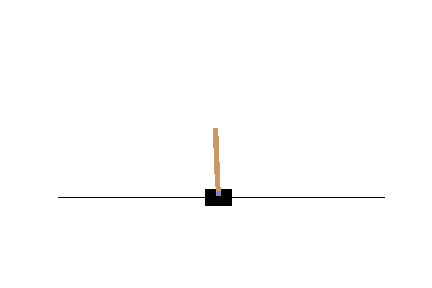
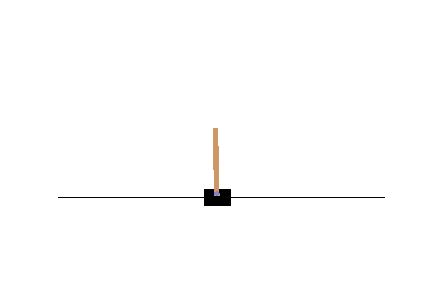
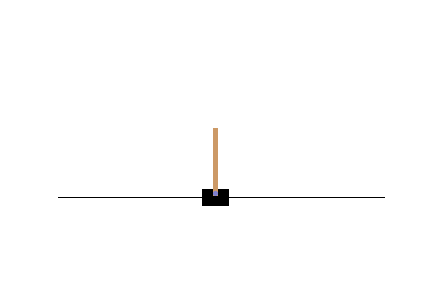
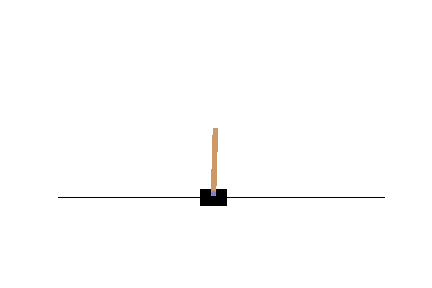
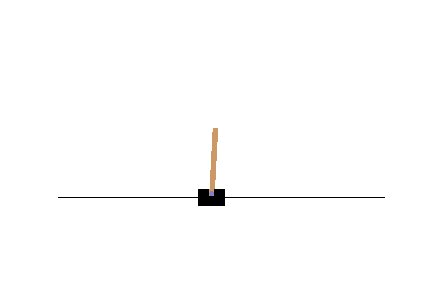
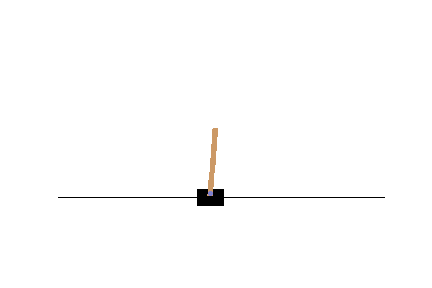
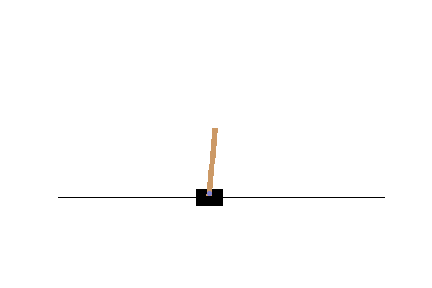
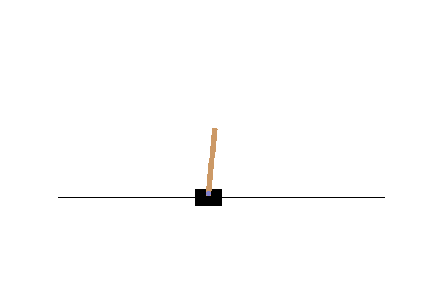
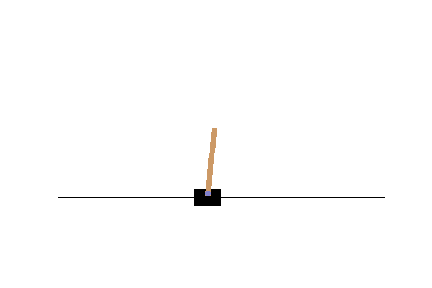
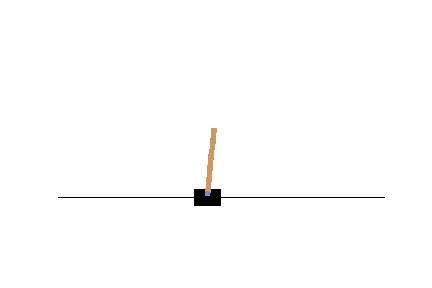
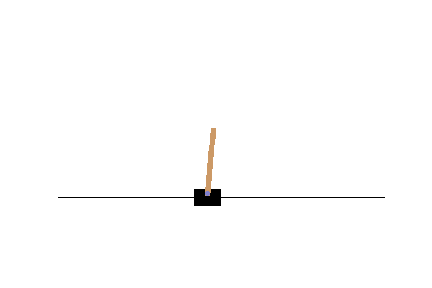
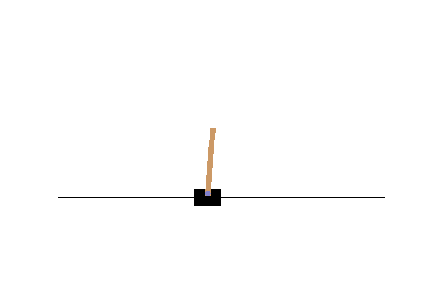
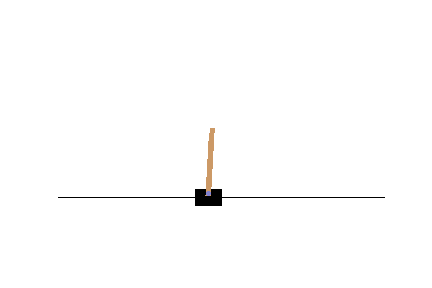
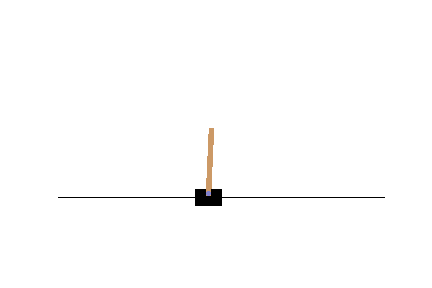
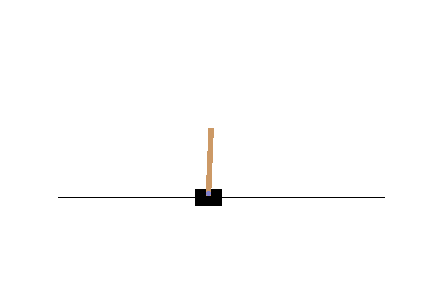
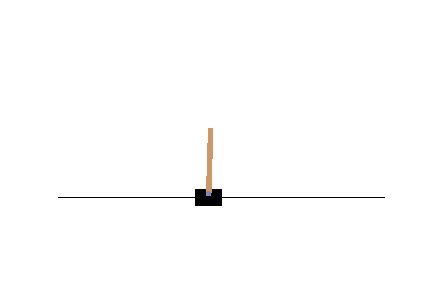
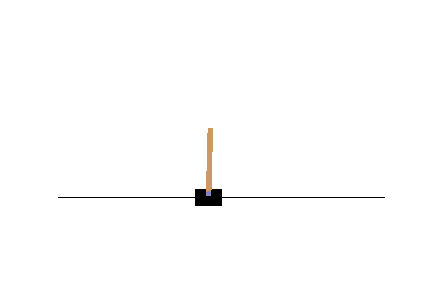
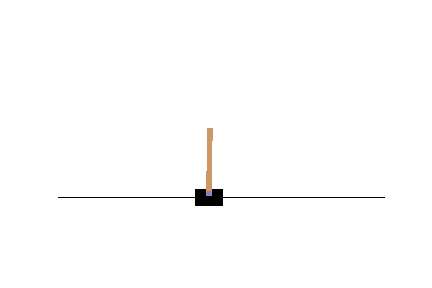
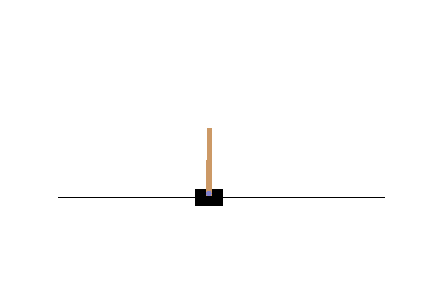
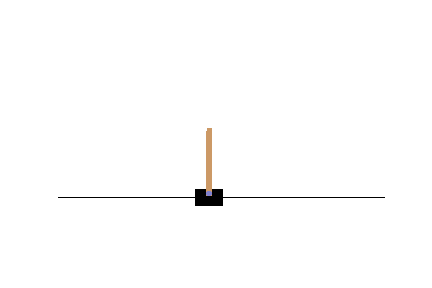
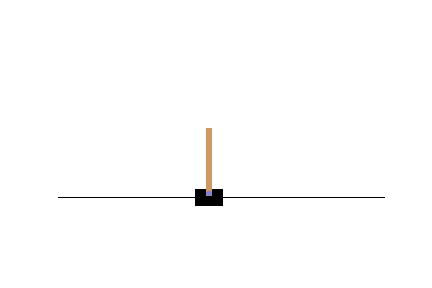
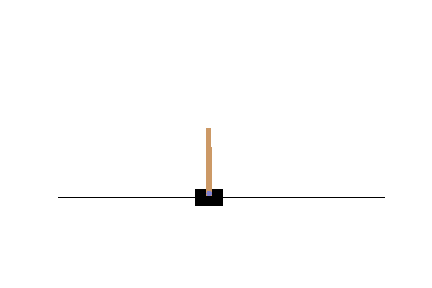
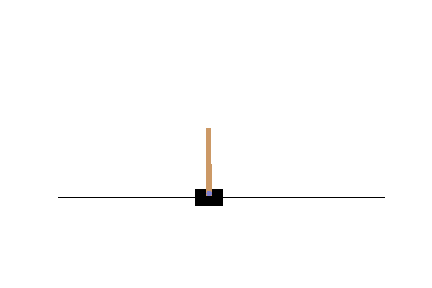
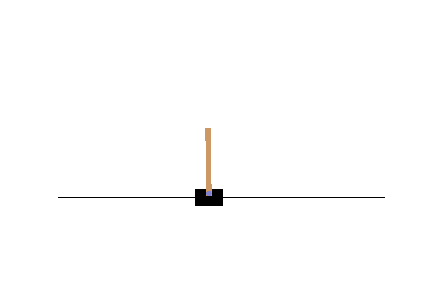
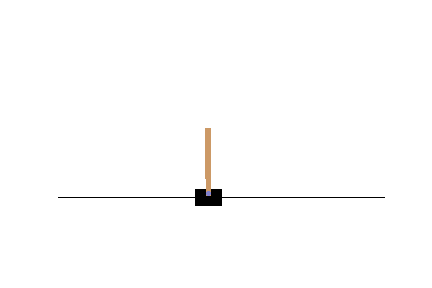
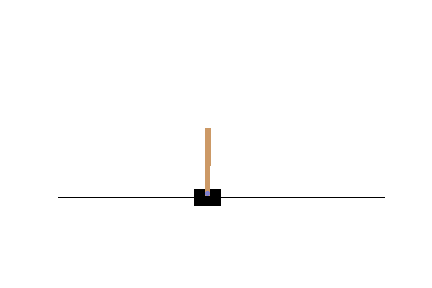
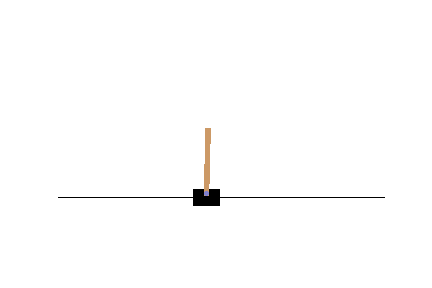
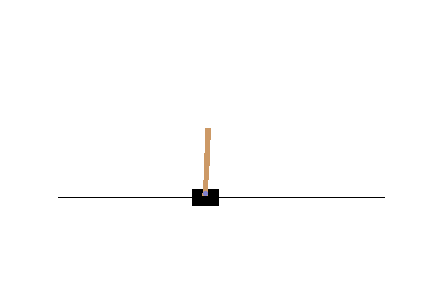
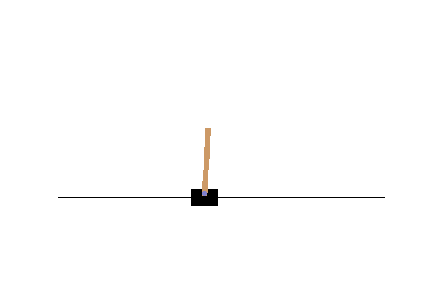
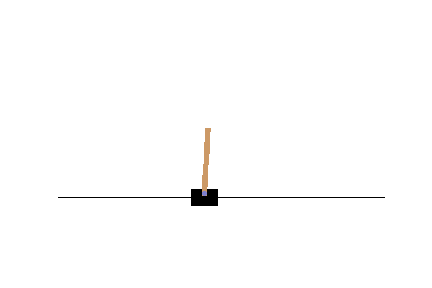
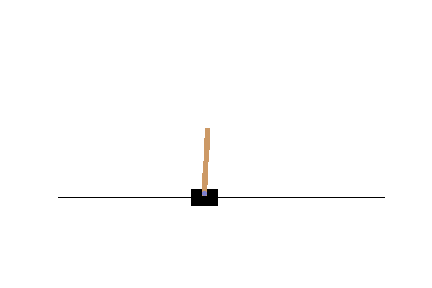
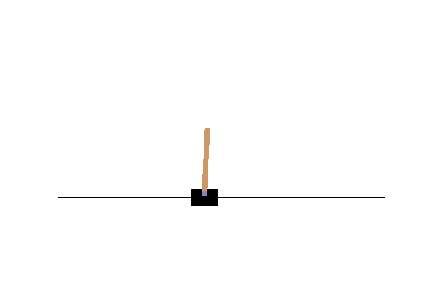
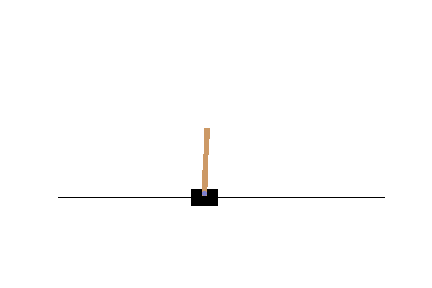
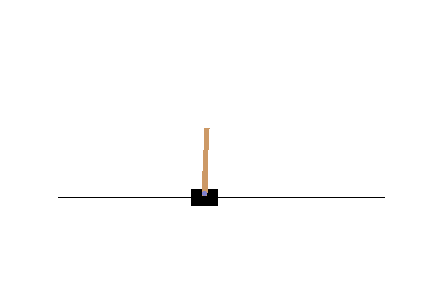
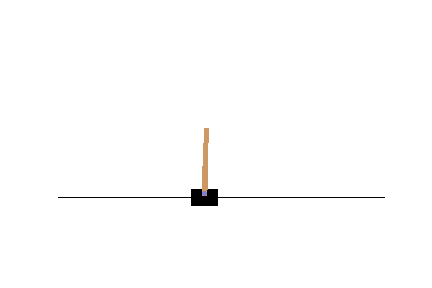
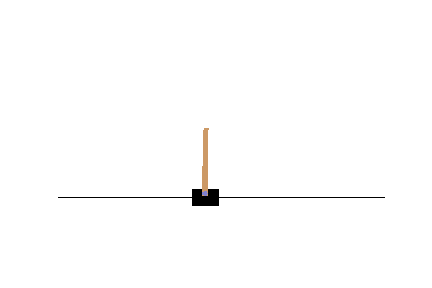
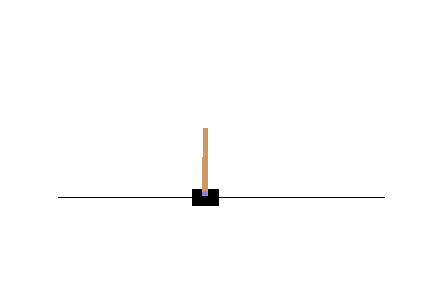
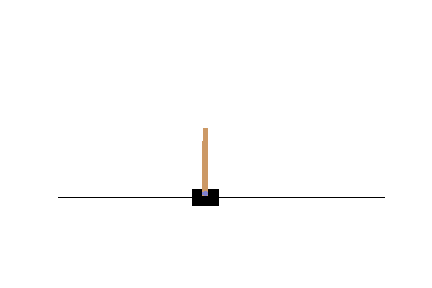
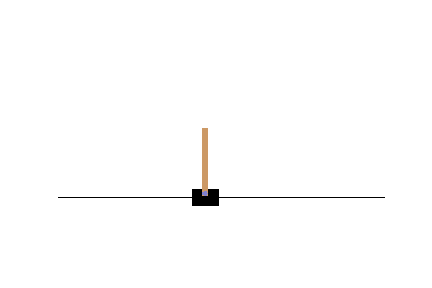
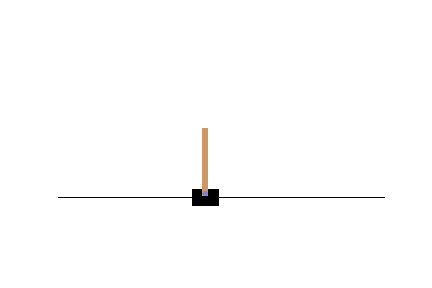
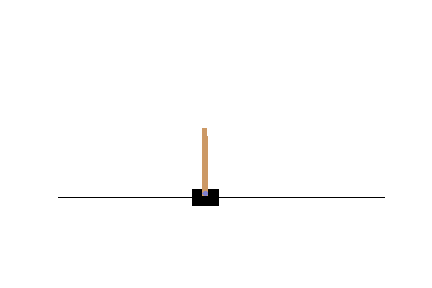
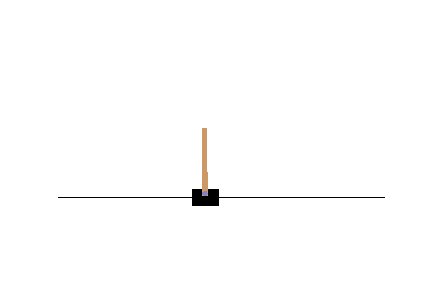
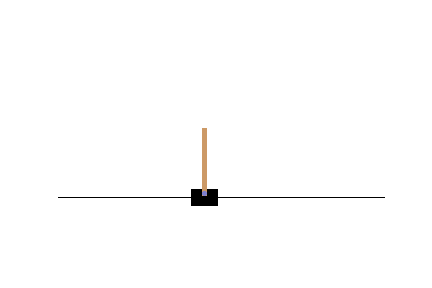
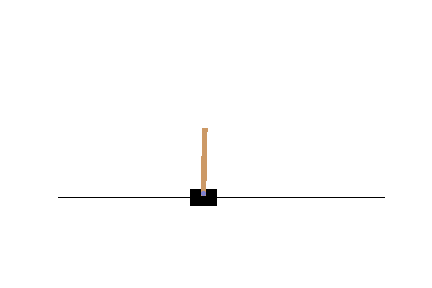
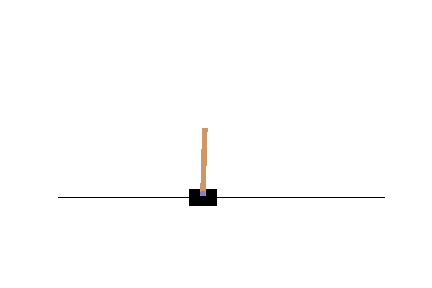
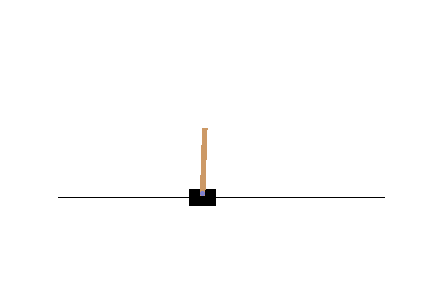
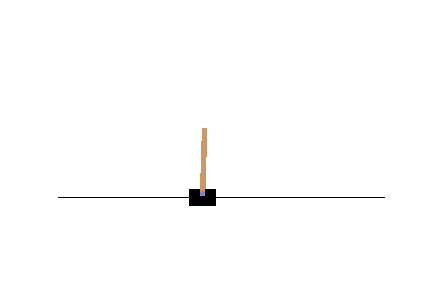
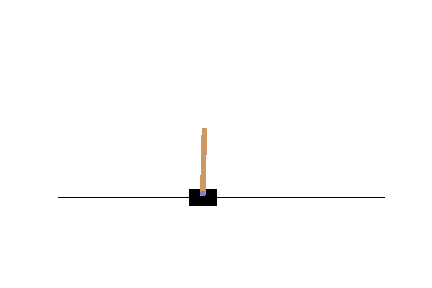
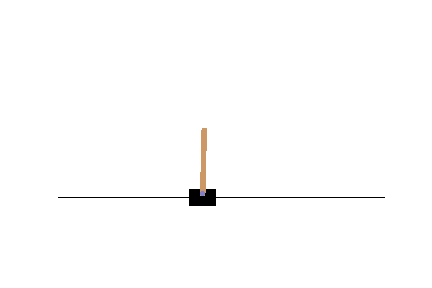
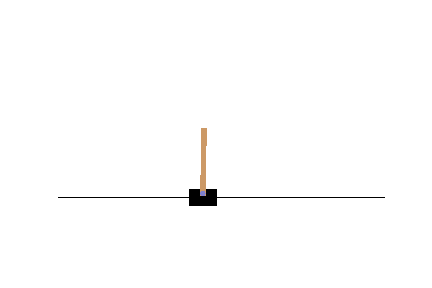
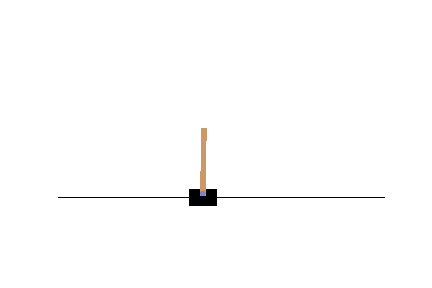
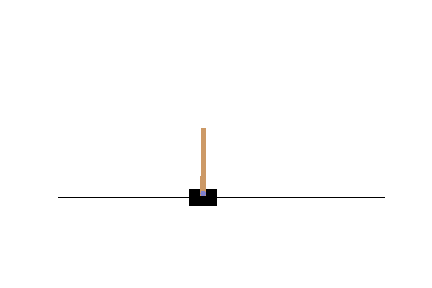
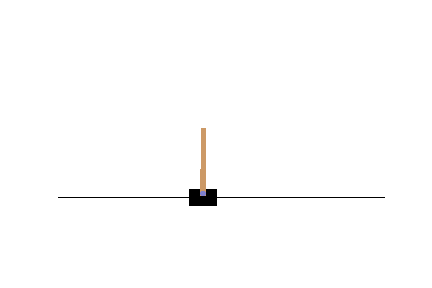
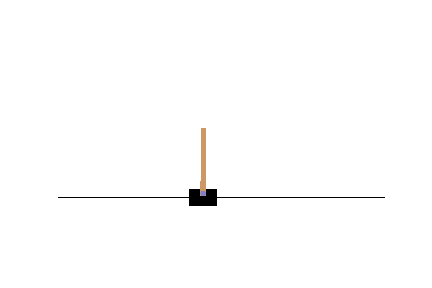
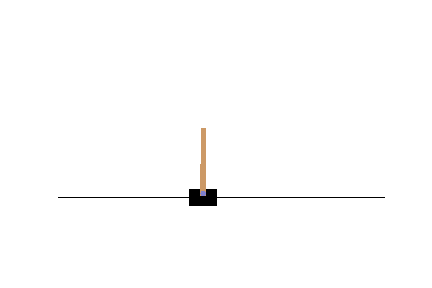
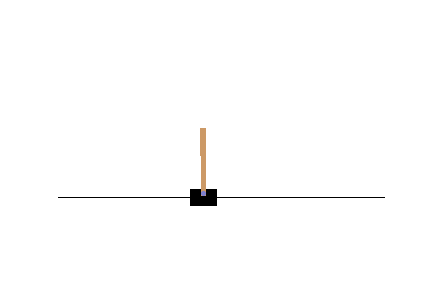
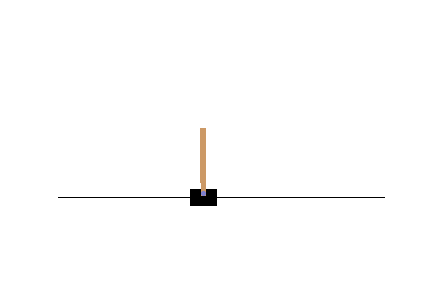
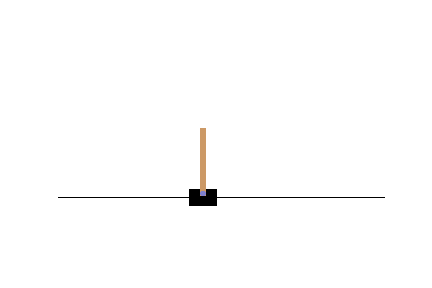
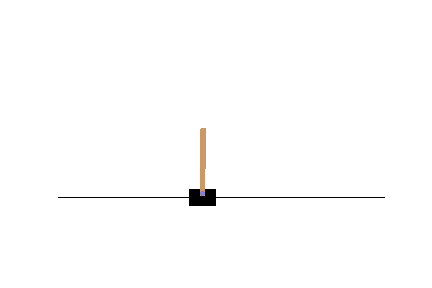
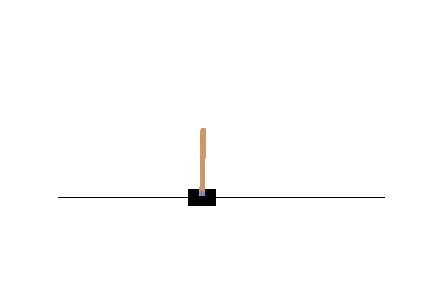
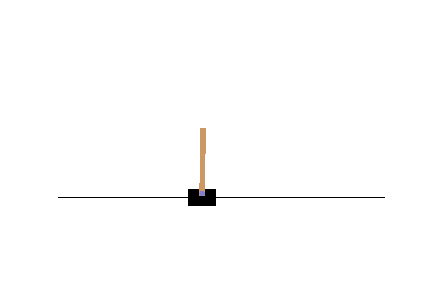
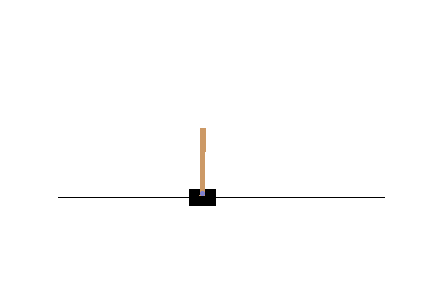
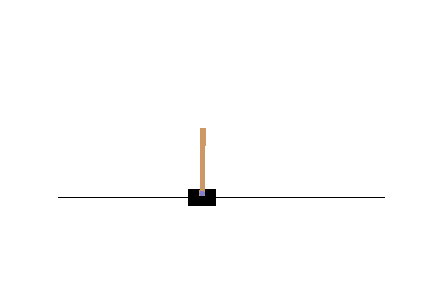
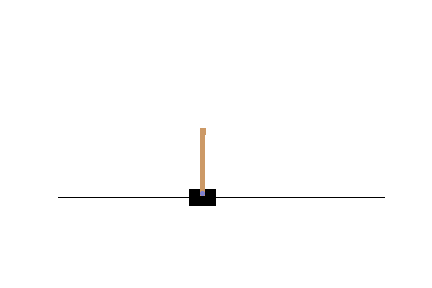
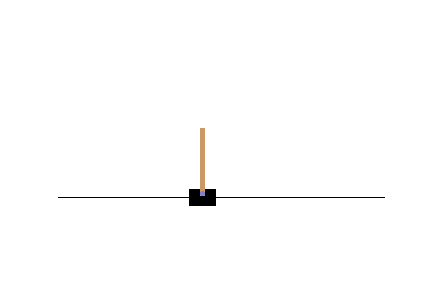
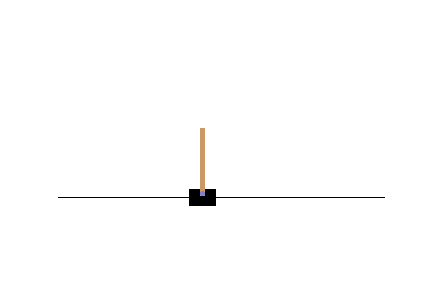
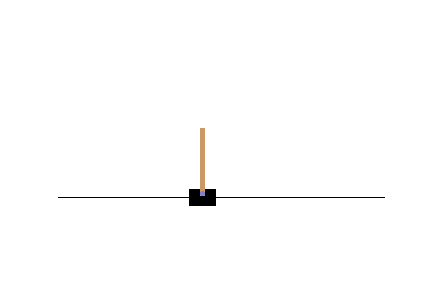
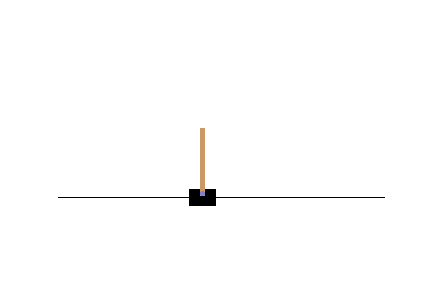
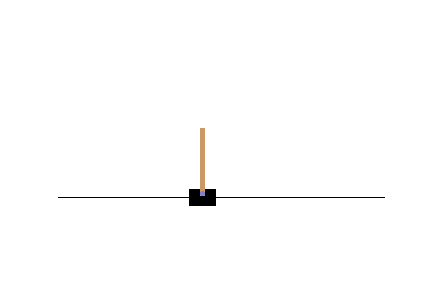
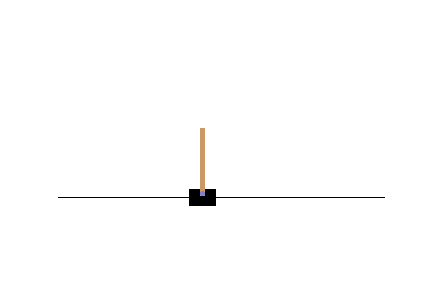
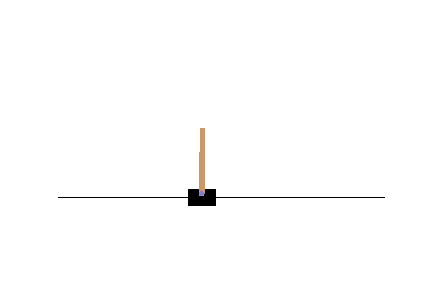
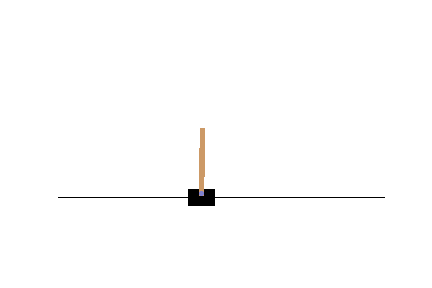
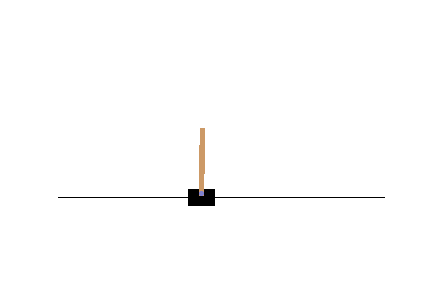
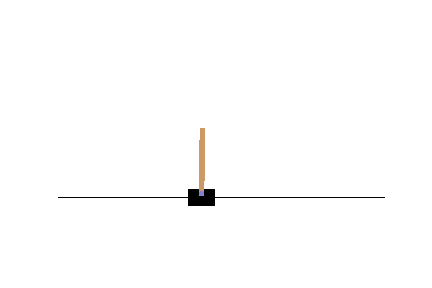
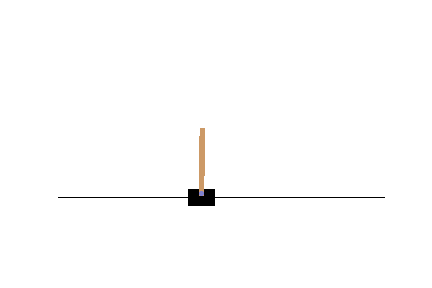
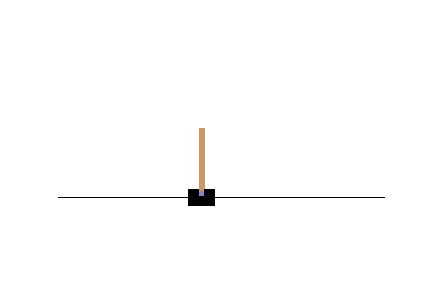
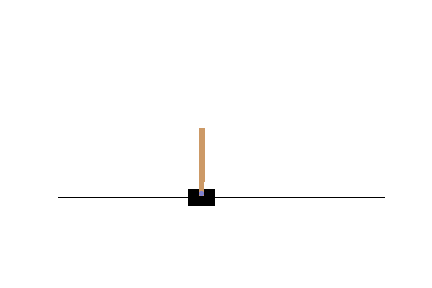
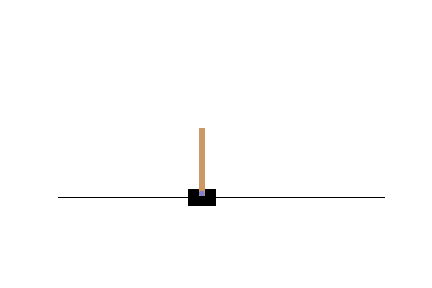
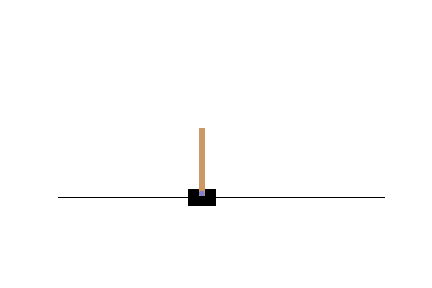
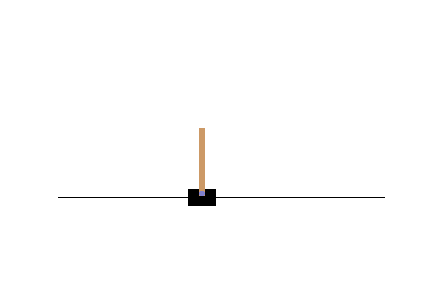
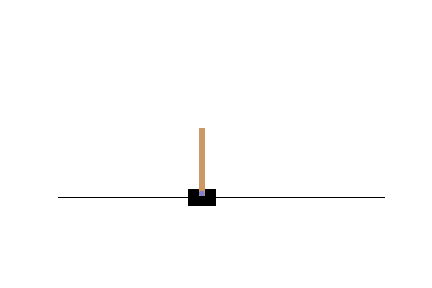
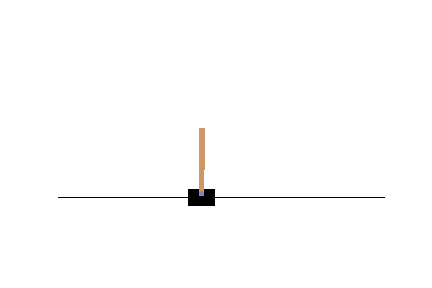
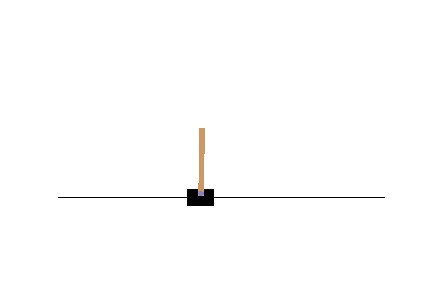
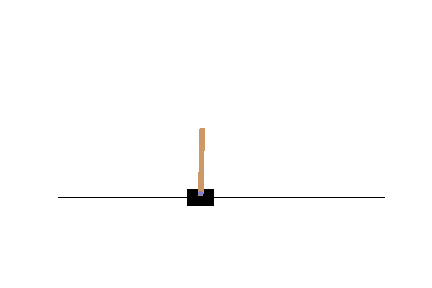
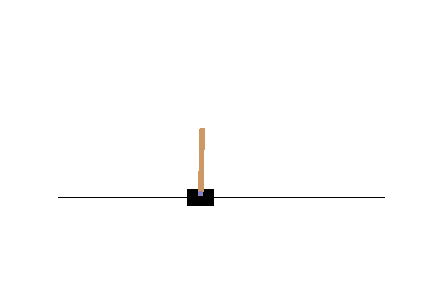
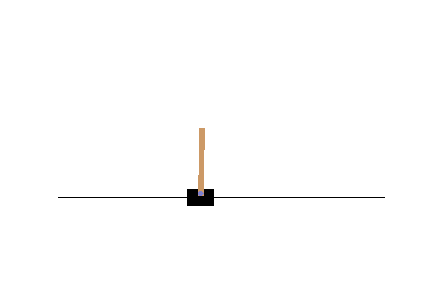
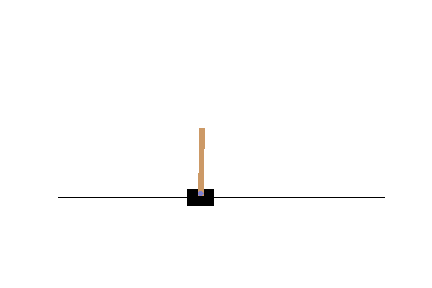
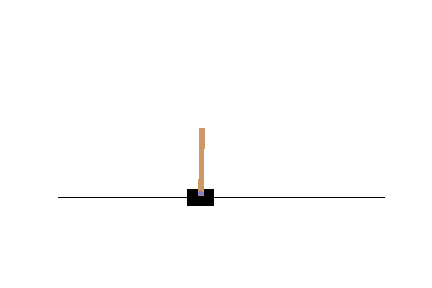
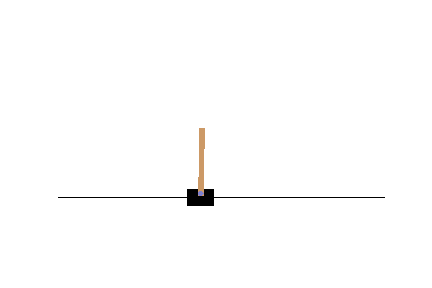
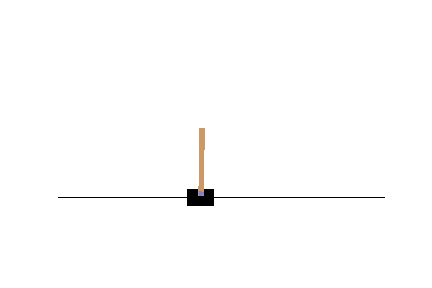
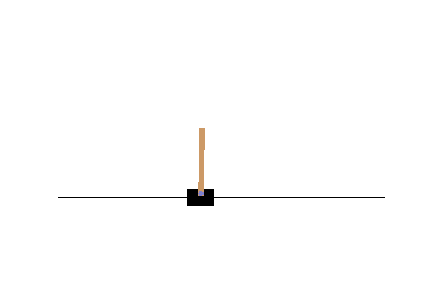
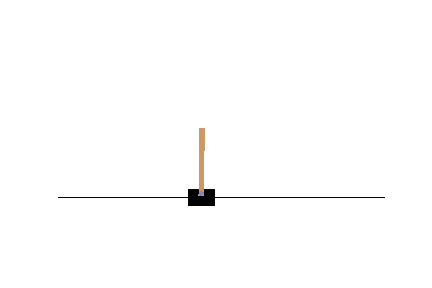

In [6]:
observation = env.reset()

frames = []
for _ in range(num_max_step):
    state = learn.digitize_state(env, observation, num_dizitized)
    action = learning.get_action(state, episode)
    observation, reward, done, info =  env.step(action)
    frames.append(env.render(mode = 'rgb_array'))
    if done:
        break
        
disp.display_frames_as_gif(frames)

## SARSA法で訓練

In [7]:
learning = QLearning(num_state, num_action)

observation = env.reset()

rewards_sarsa = []
for episode in range(num_max_episode):
    total_reward = 0
    observation = env.reset()
    state = learn.digitize_state(env, observation, num_dizitized)
    action = learning.get_action(state, episode)
    
    for step in range(num_max_step):
        next_observation, reward, done, info =  env.step(action)
        if done:
            if step < num_max_step-5:
                reward = -200
            else:
                reward = 1
        next_state = learn.digitize_state(env, next_observation, num_dizitized)
        next_action = learning.get_action(next_state, episode)
        learning.update_q_table_sarsa(action, next_action, state, next_state, reward)
        total_reward += reward
        state = next_state
        action = next_action
        observation = next_observation
        if done:
            if episode % 100 == 0:
                print('episode: {}, total_reward: {}'.format(episode, total_reward))
            rewards_sarsa.append(total_reward)
            break

episode: 0, total_reward: -192.0
episode: 100, total_reward: -156.0
episode: 200, total_reward: 200.0
episode: 300, total_reward: 200.0
episode: 400, total_reward: -27.0
episode: 500, total_reward: -82.0
episode: 600, total_reward: 200.0
episode: 700, total_reward: -50.0
episode: 800, total_reward: 200.0
episode: 900, total_reward: 200.0
episode: 1000, total_reward: 200.0
episode: 1100, total_reward: 200.0
episode: 1200, total_reward: 200.0
episode: 1300, total_reward: 200.0
episode: 1400, total_reward: 200.0
episode: 1500, total_reward: 200.0
episode: 1600, total_reward: 200.0
episode: 1700, total_reward: 200.0
episode: 1800, total_reward: 200.0
episode: 1900, total_reward: 200.0
episode: 2000, total_reward: 200.0
episode: 2100, total_reward: 200.0
episode: 2200, total_reward: 200.0
episode: 2300, total_reward: 200.0
episode: 2400, total_reward: 200.0
episode: 2500, total_reward: 200.0
episode: 2600, total_reward: 200.0
episode: 2700, total_reward: 200.0
episode: 2800, total_reward: 2

### 学習後のQ値でシュミレーション


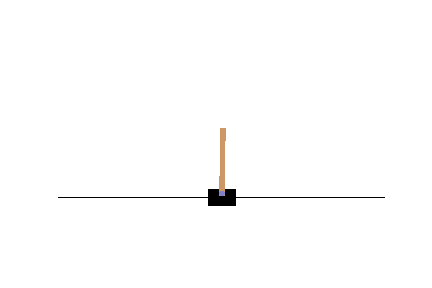
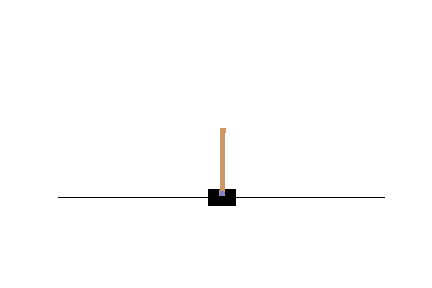
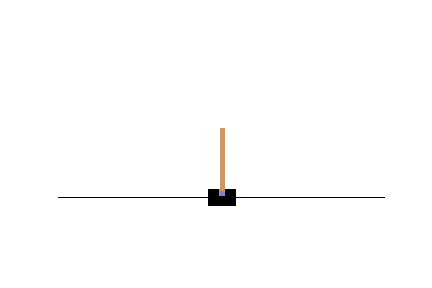
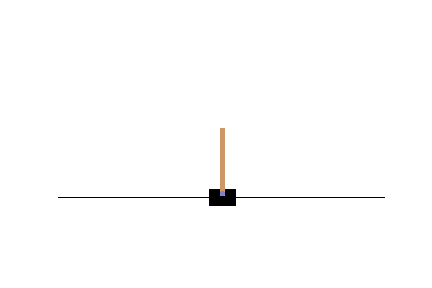
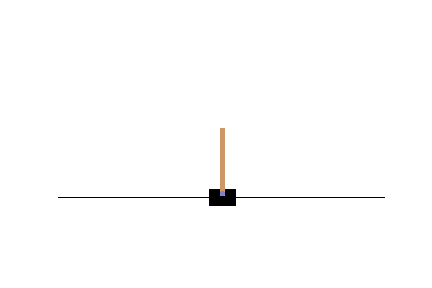
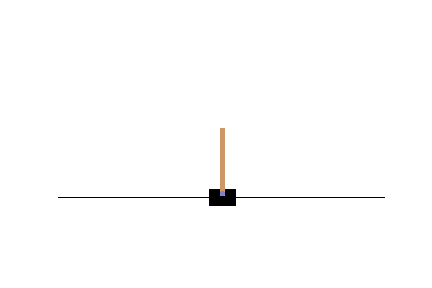
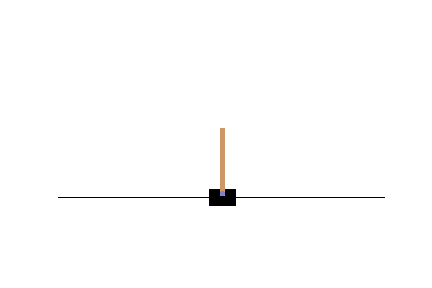
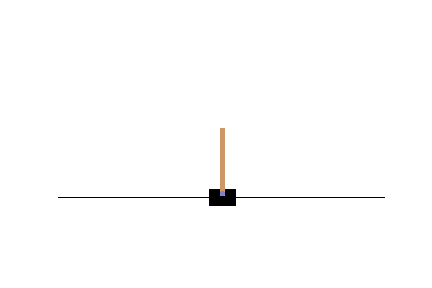
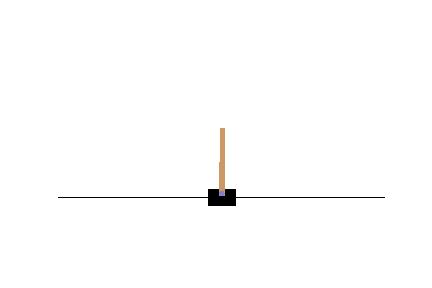
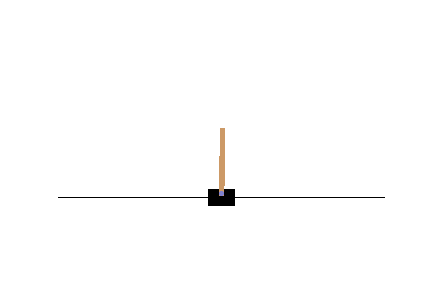
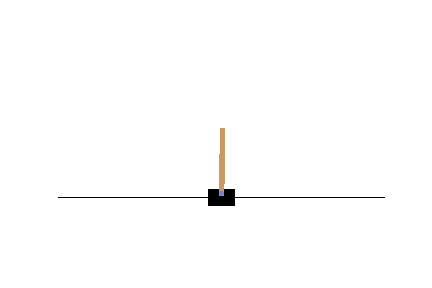
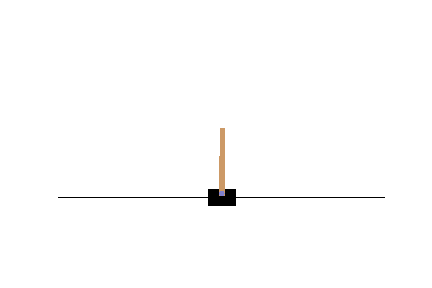
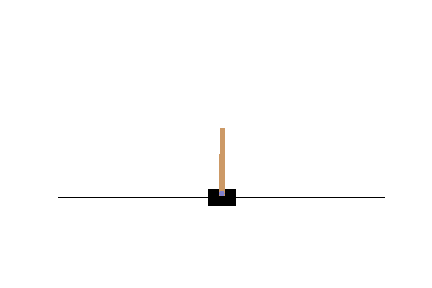
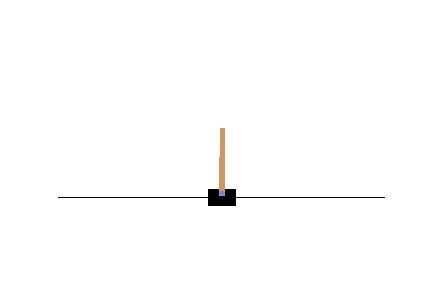
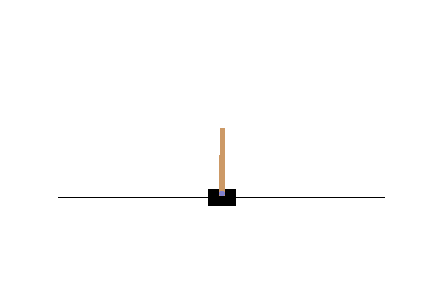
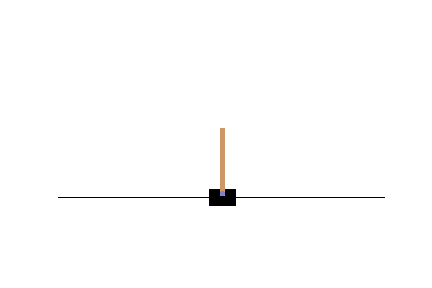
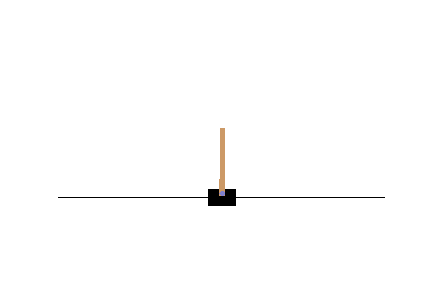
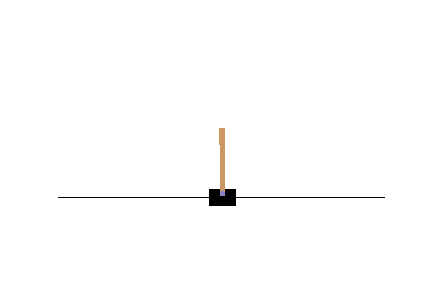
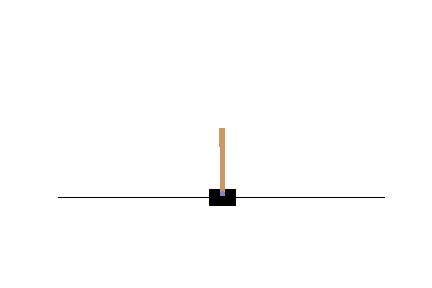
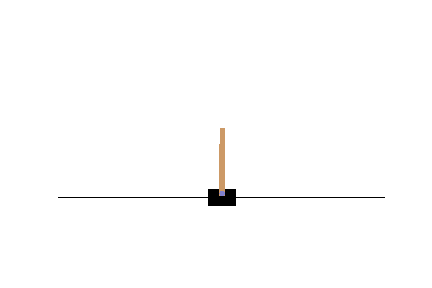
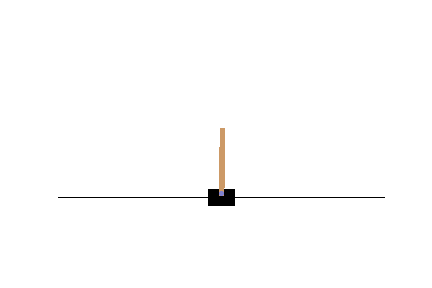
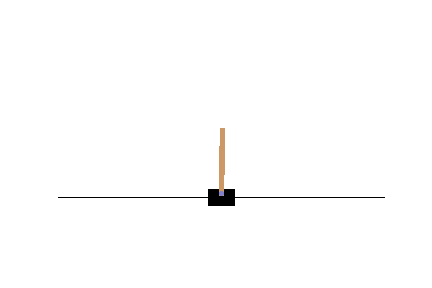
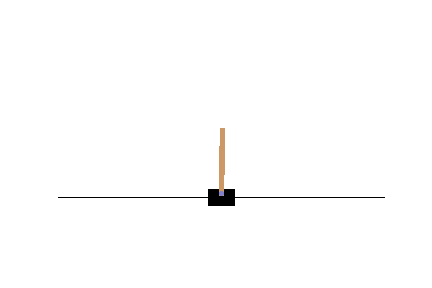
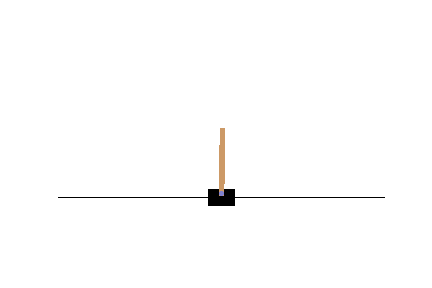
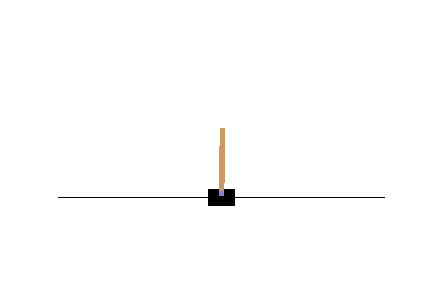
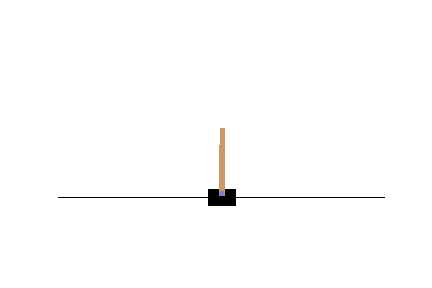
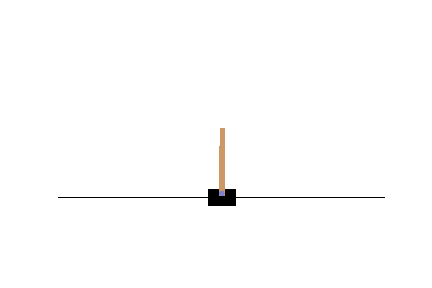
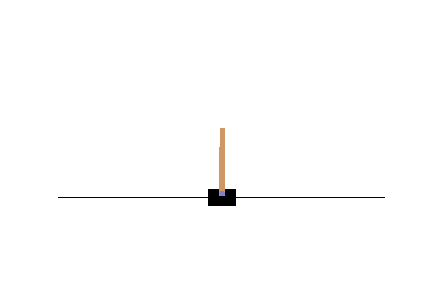
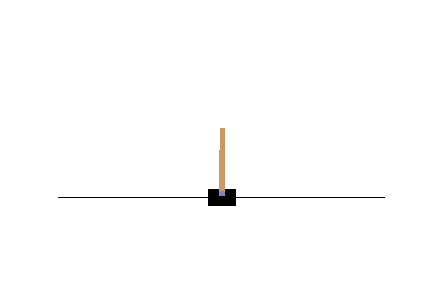
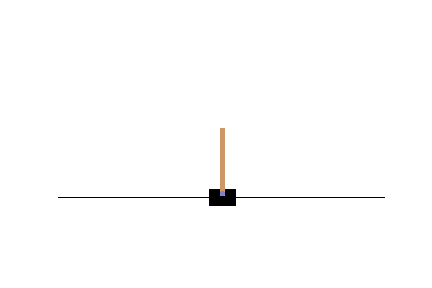
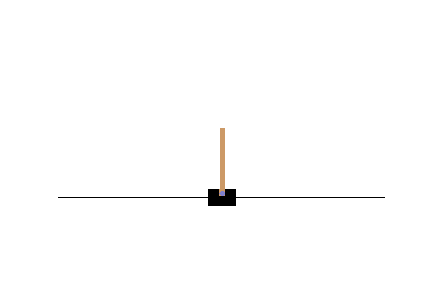
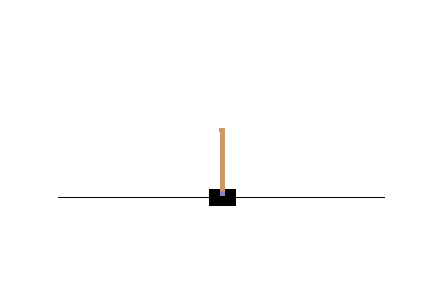
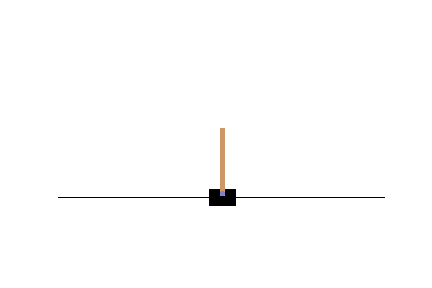
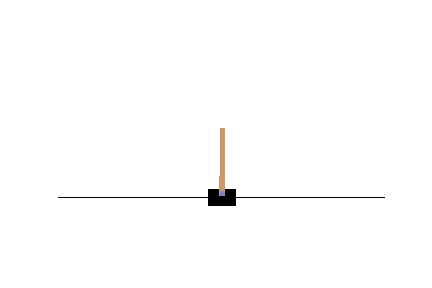
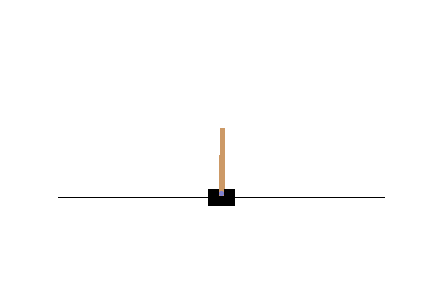
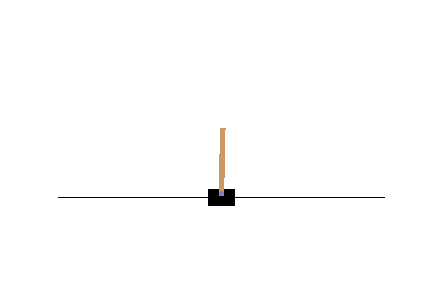
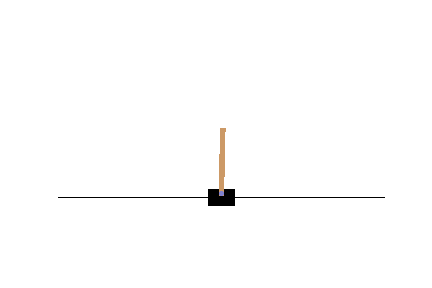
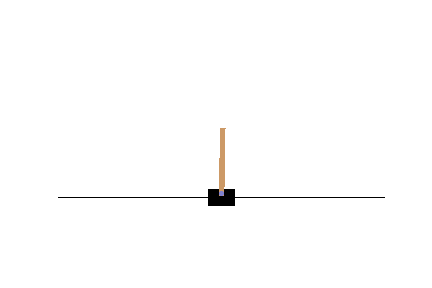
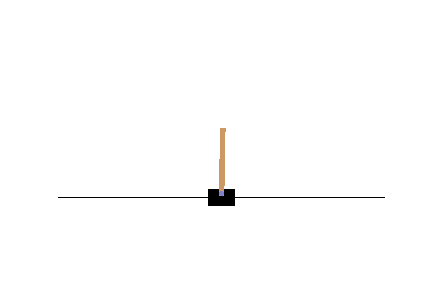
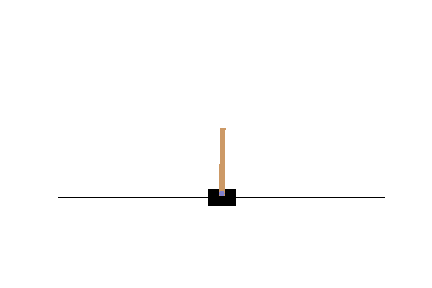
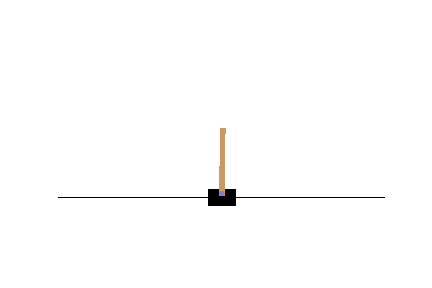
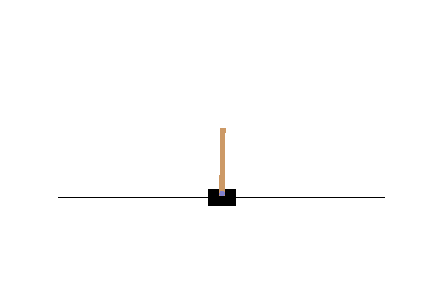
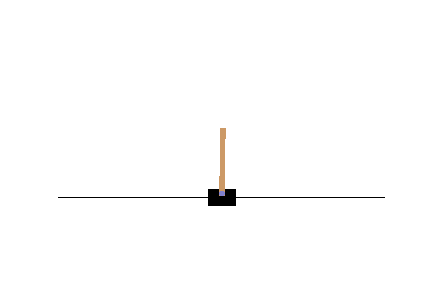
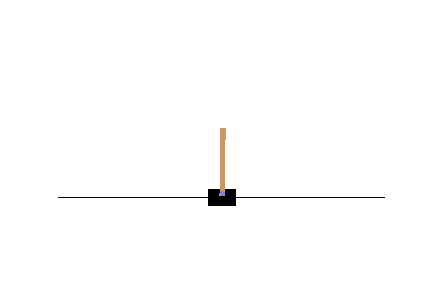
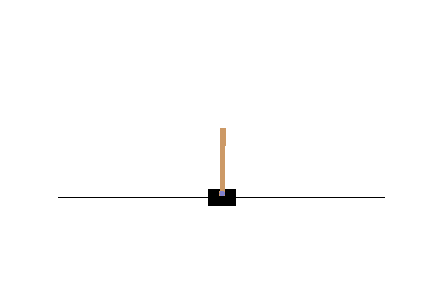
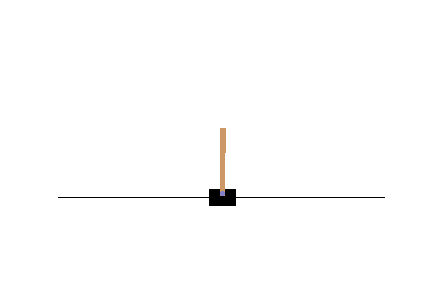
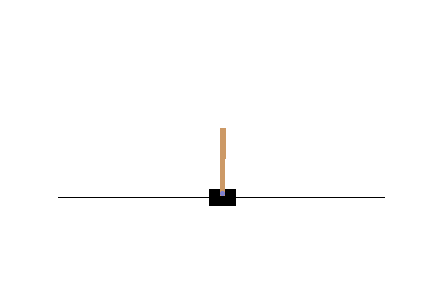
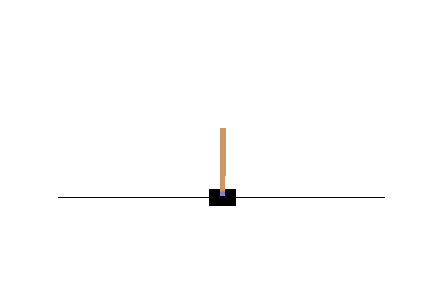
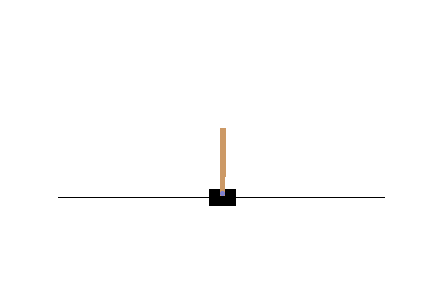
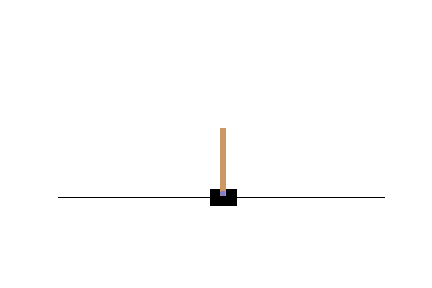
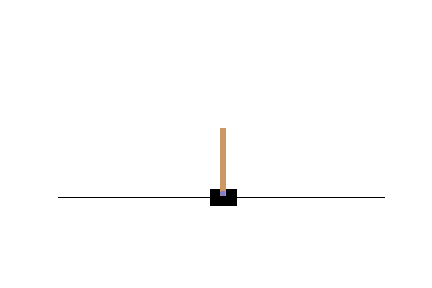
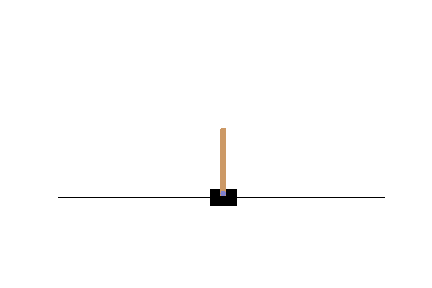
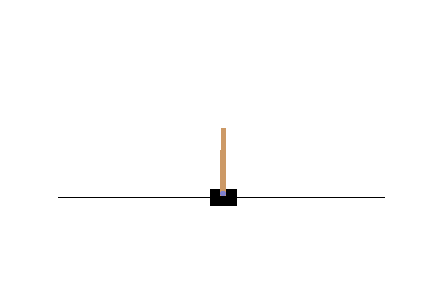
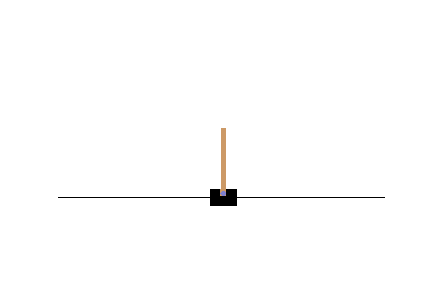
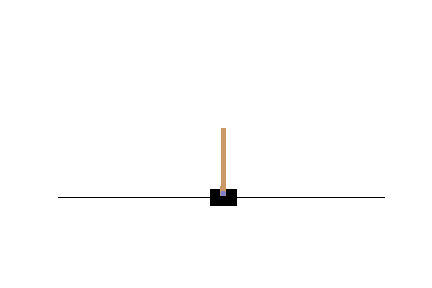
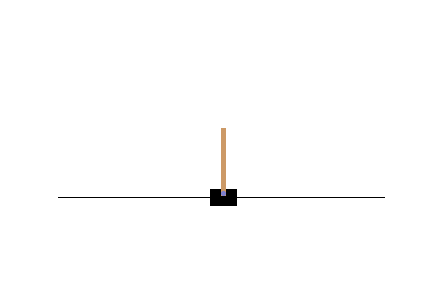
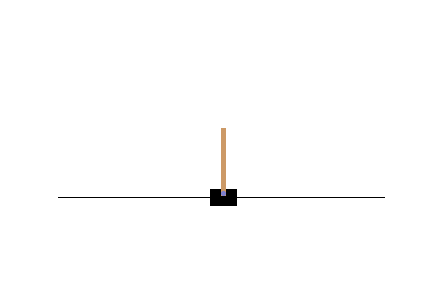
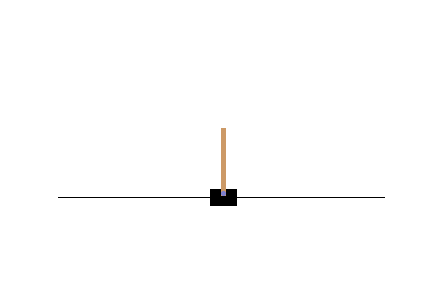
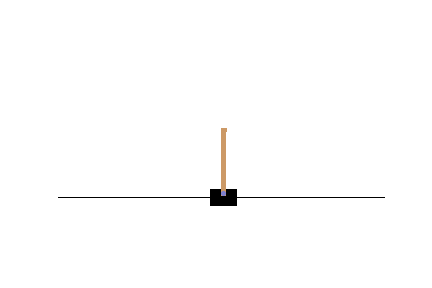
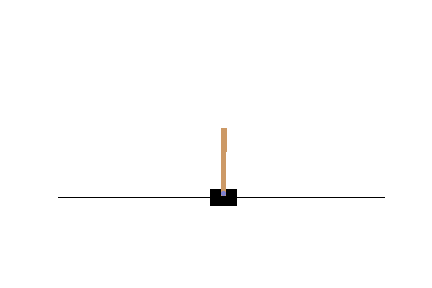
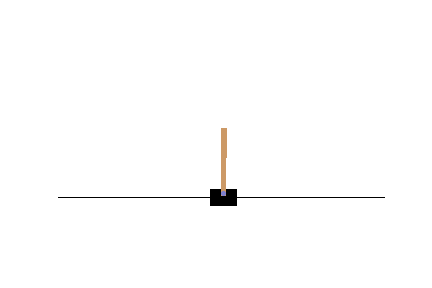
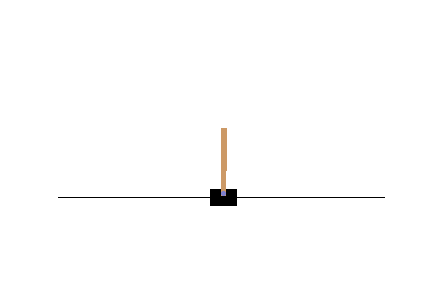
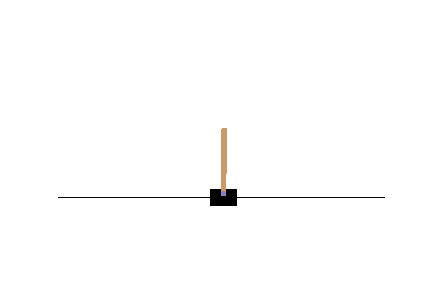
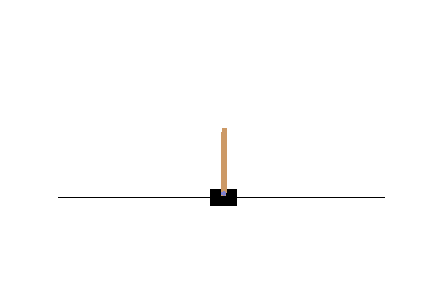
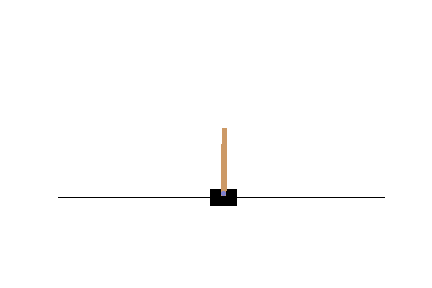
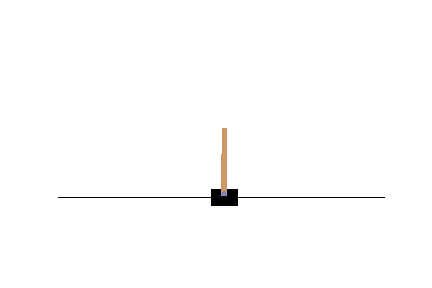
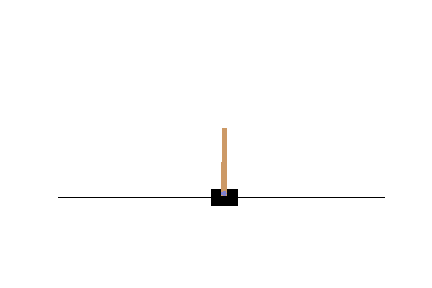
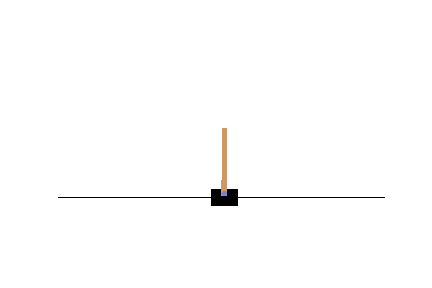
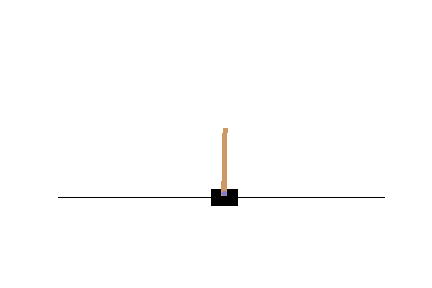
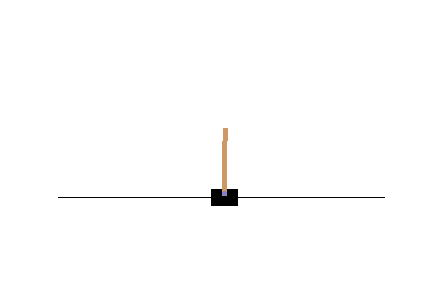
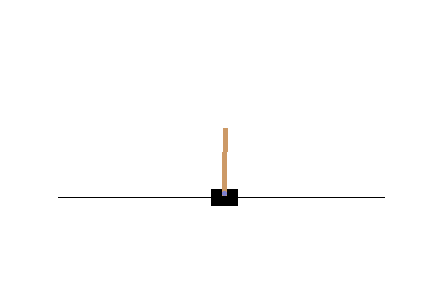
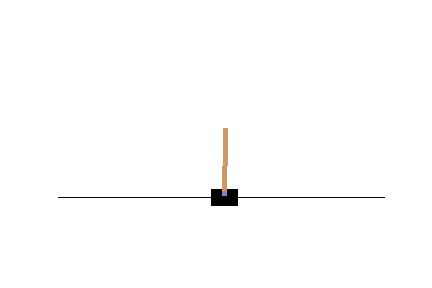
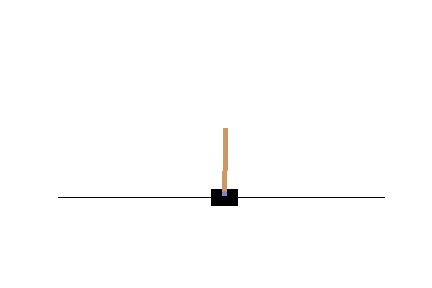
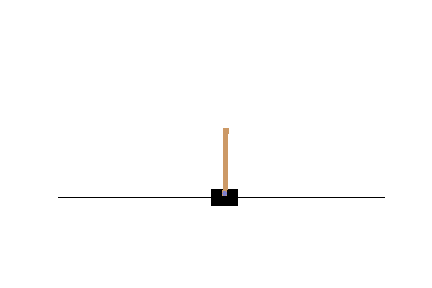
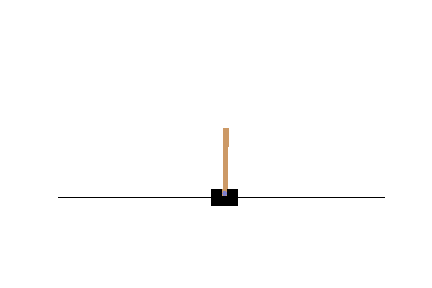
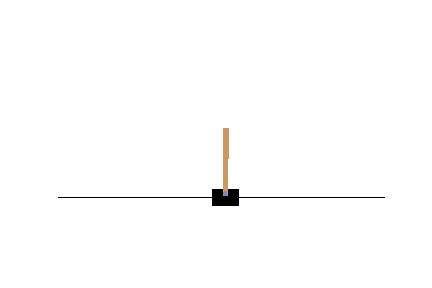
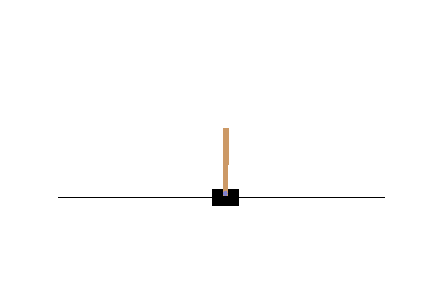
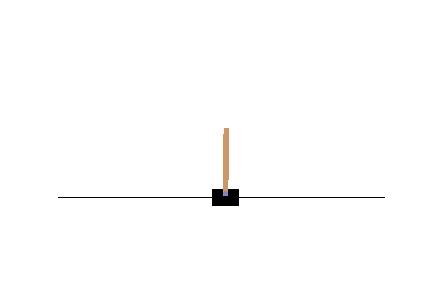
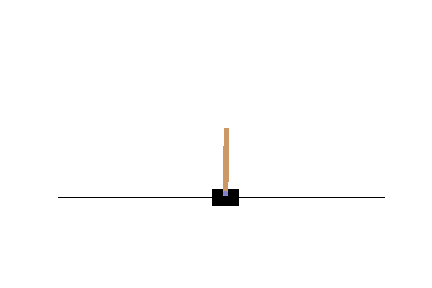
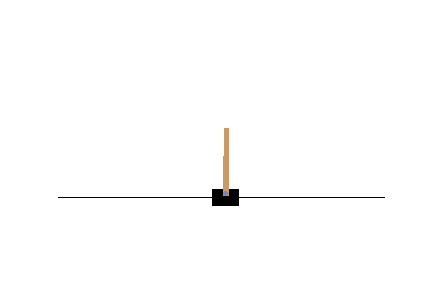
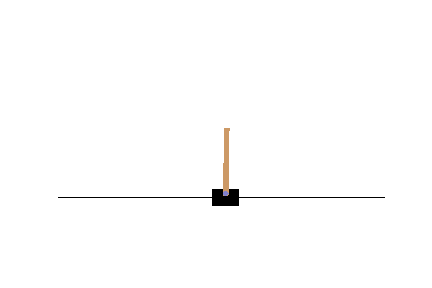
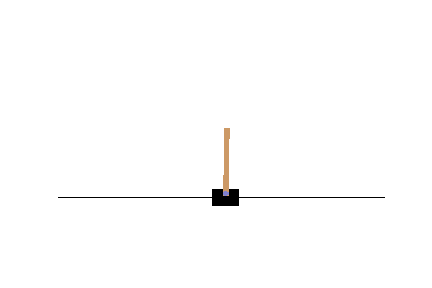
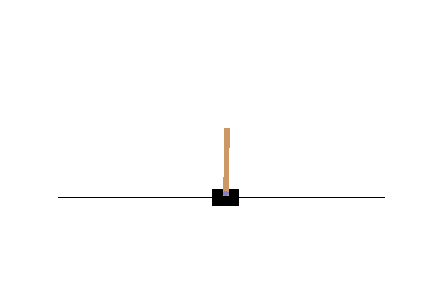
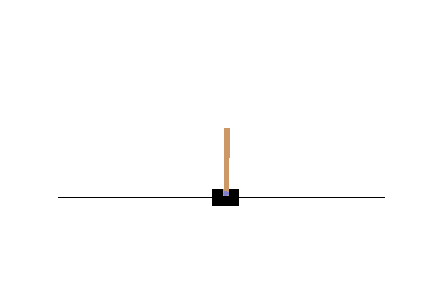
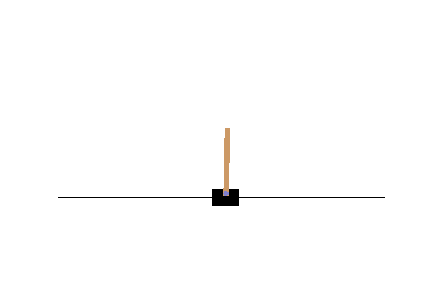
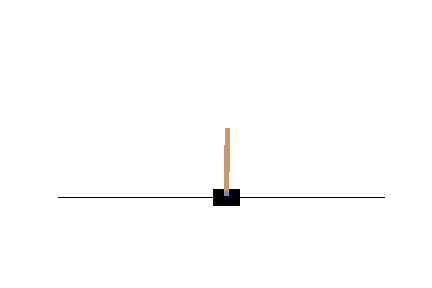
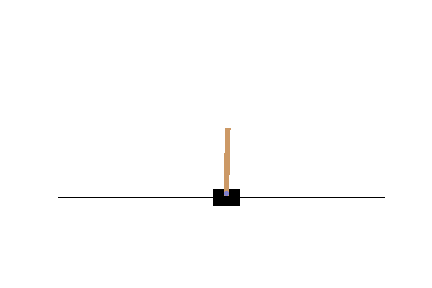
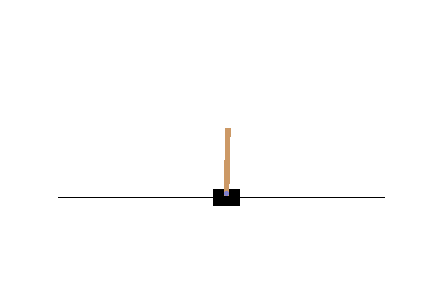
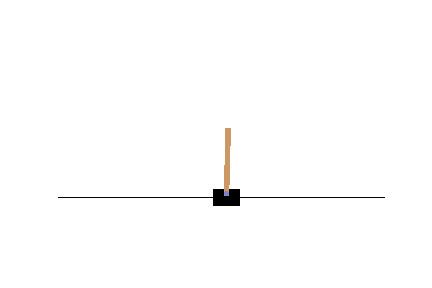
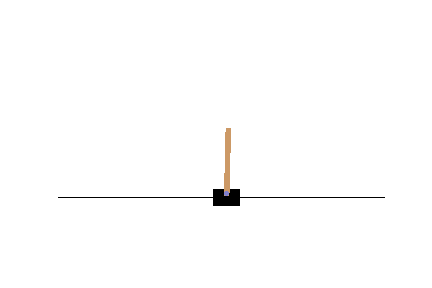
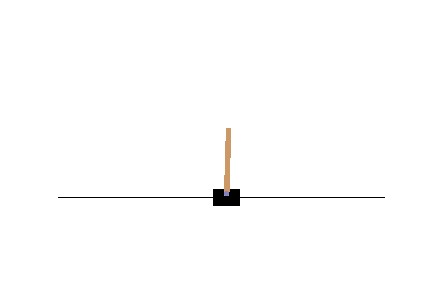
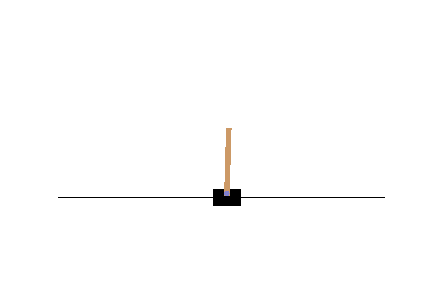
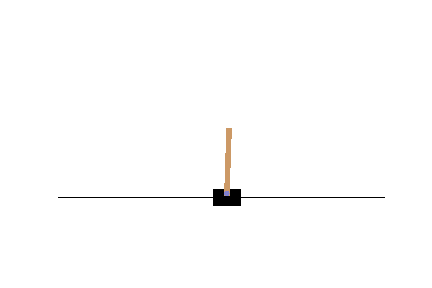
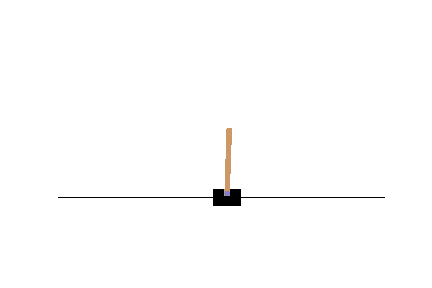
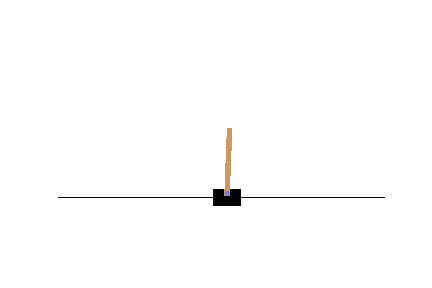
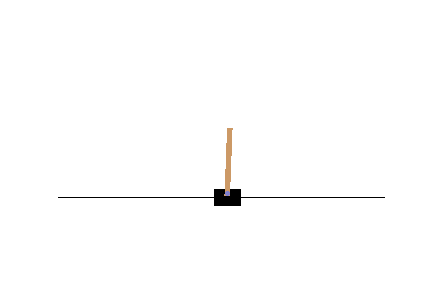
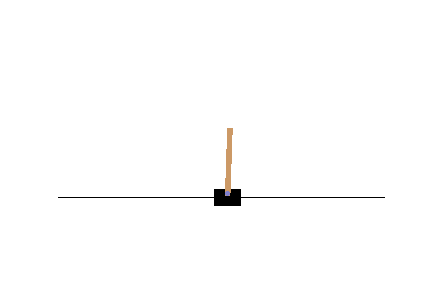
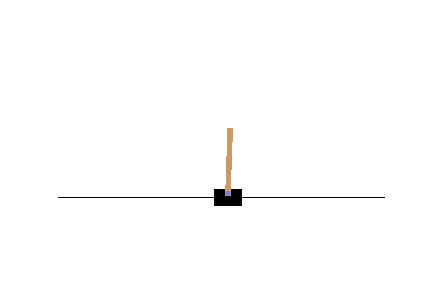
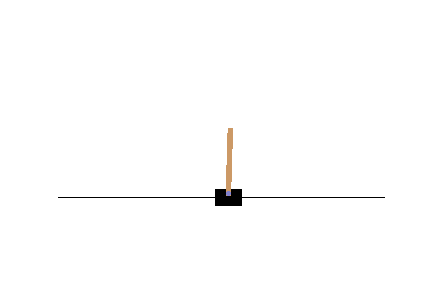
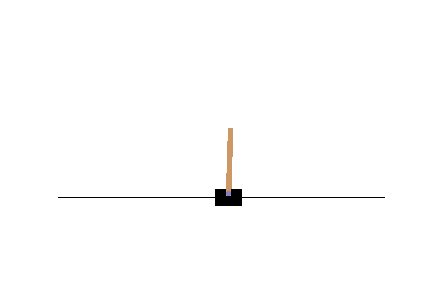
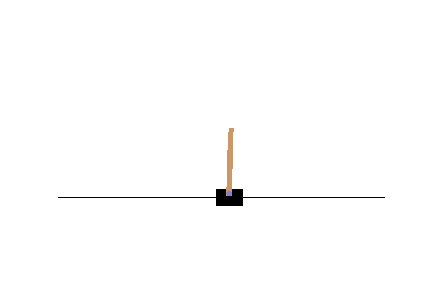
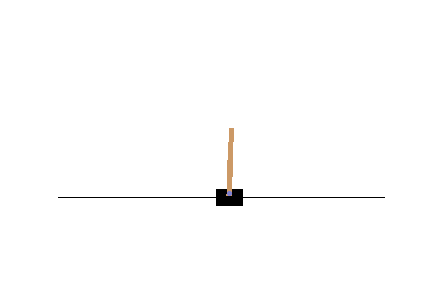
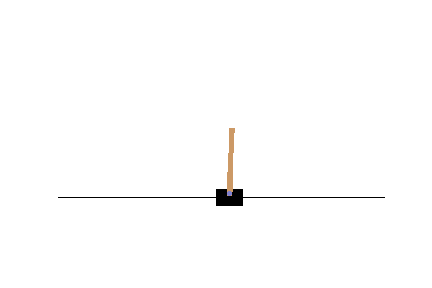
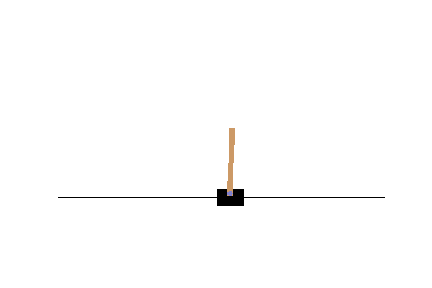
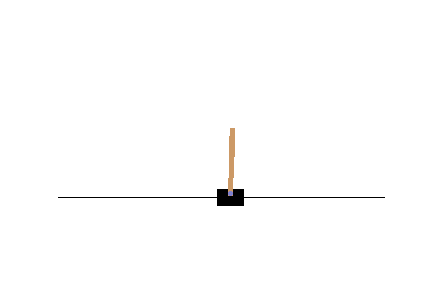
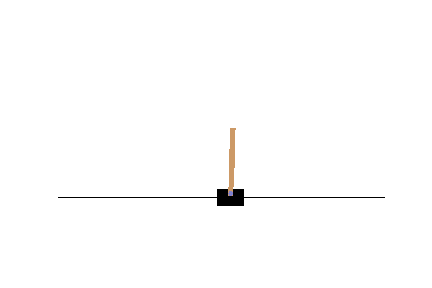
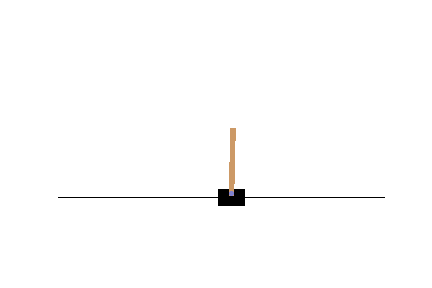
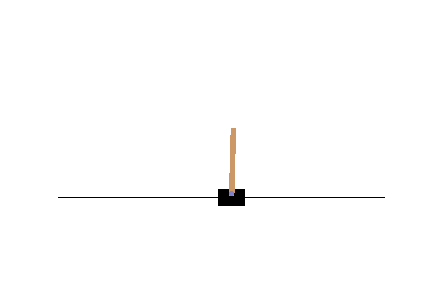
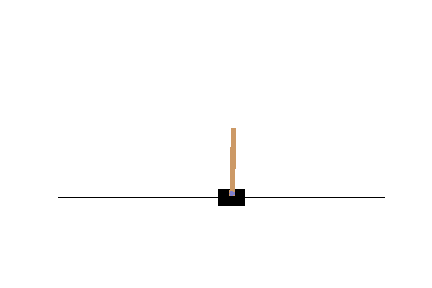
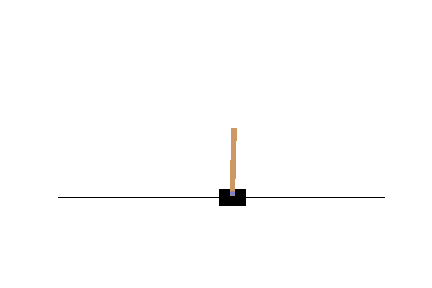
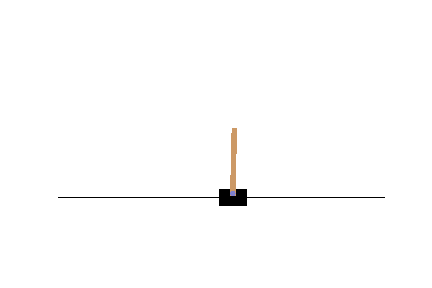
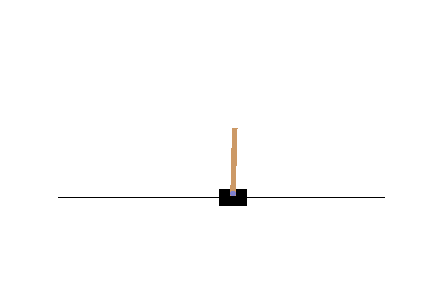
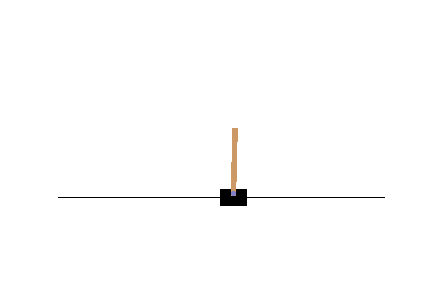
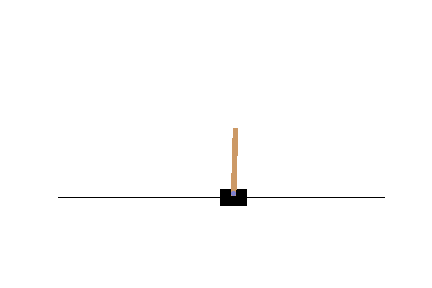
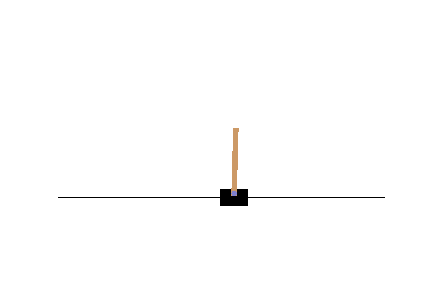
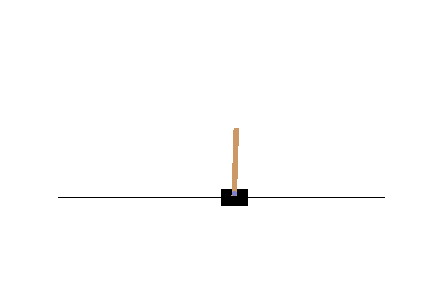
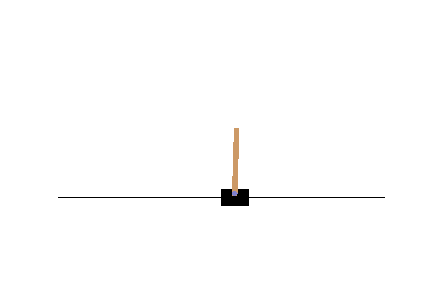
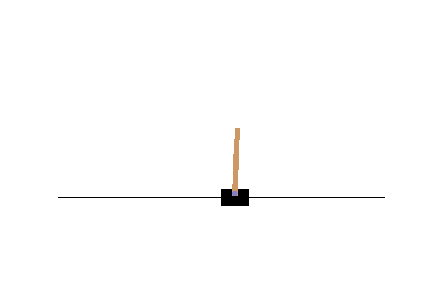
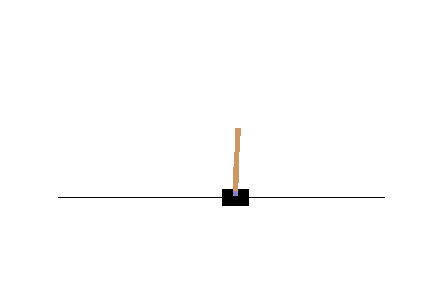
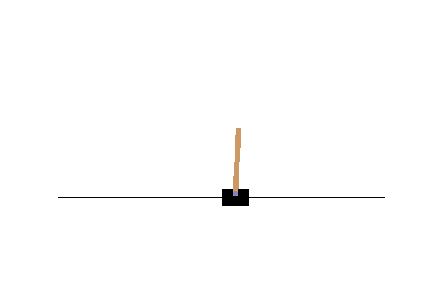
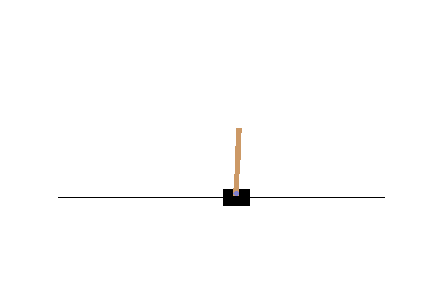
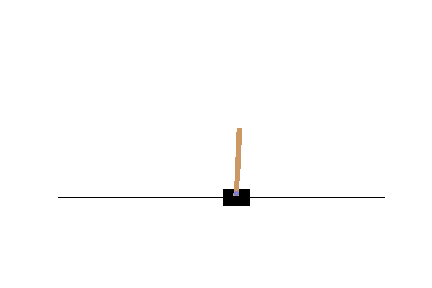
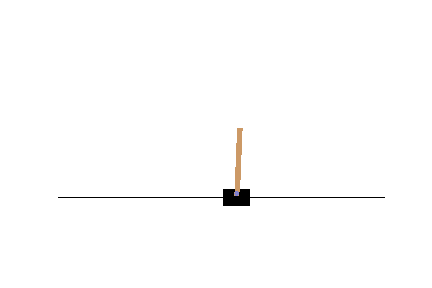
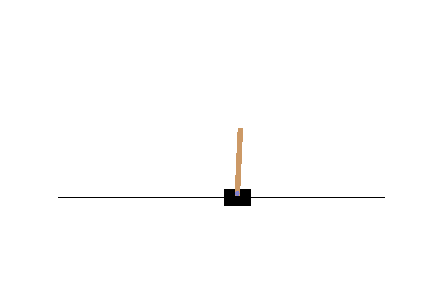
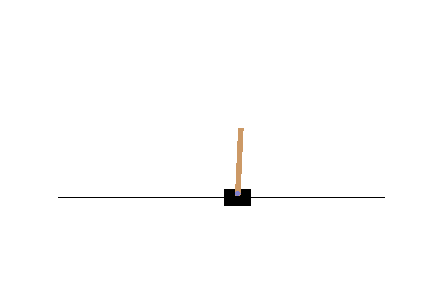
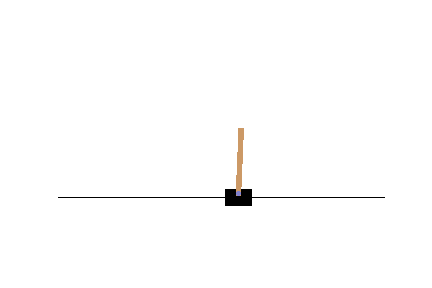
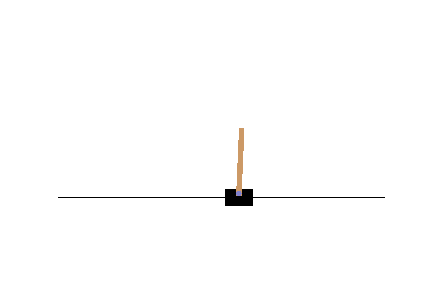
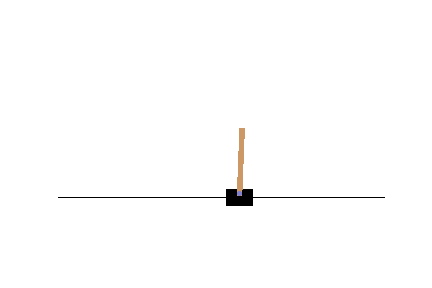
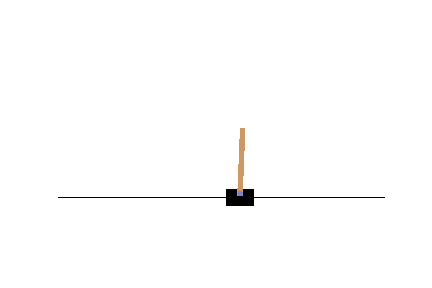
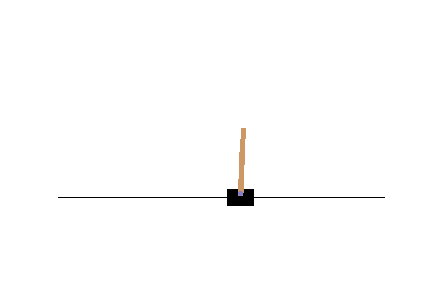
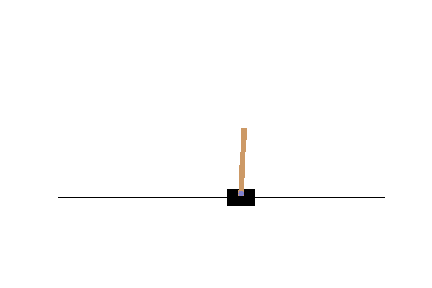
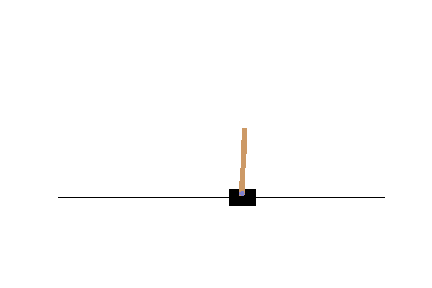
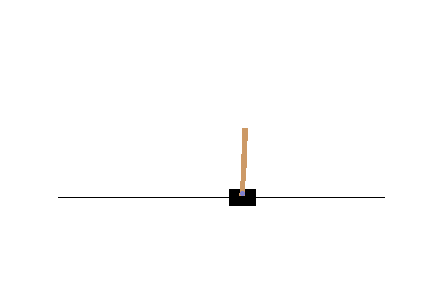
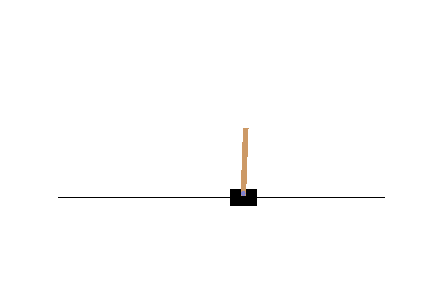
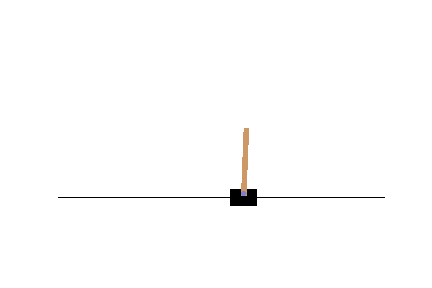
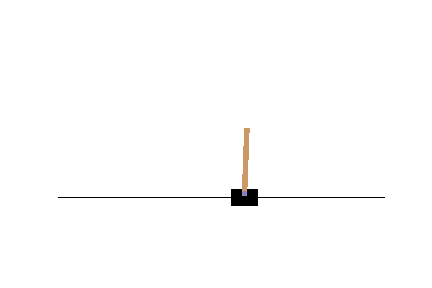
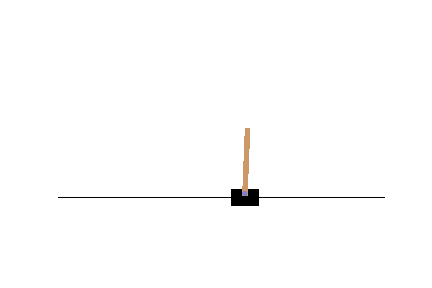
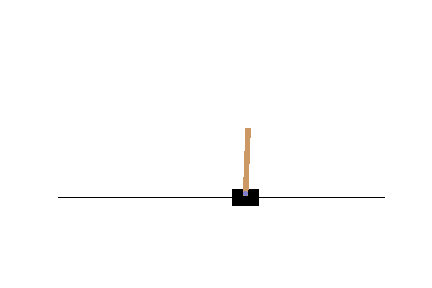
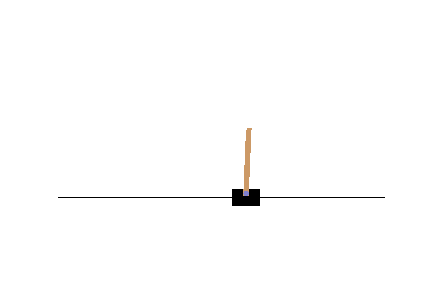
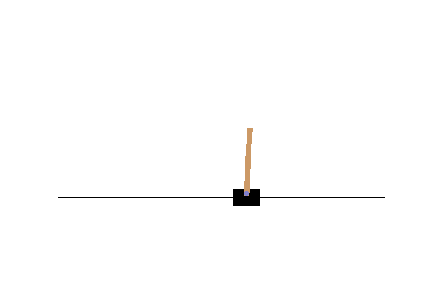
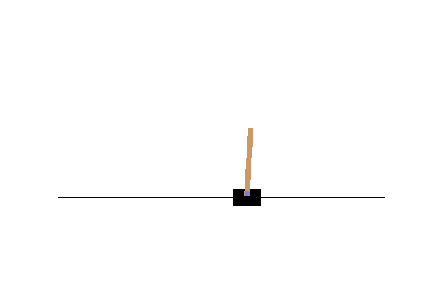
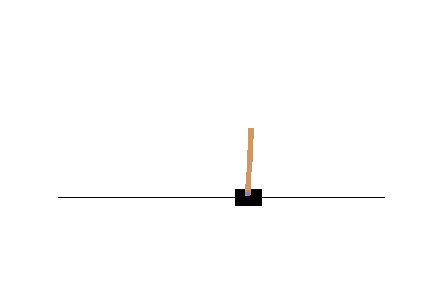
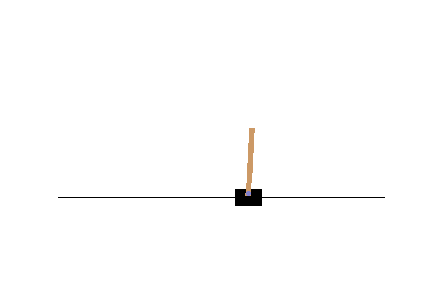
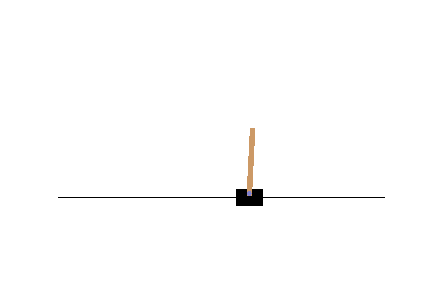
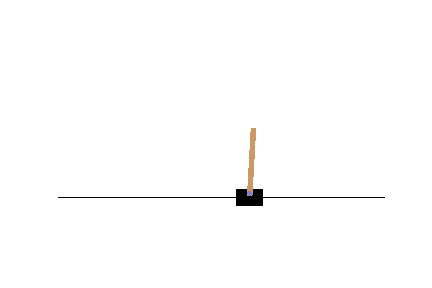
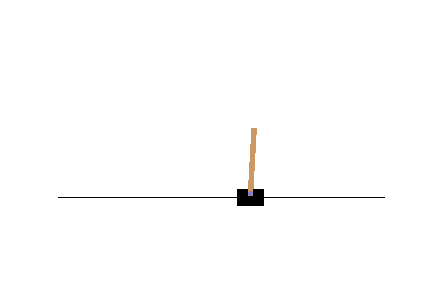
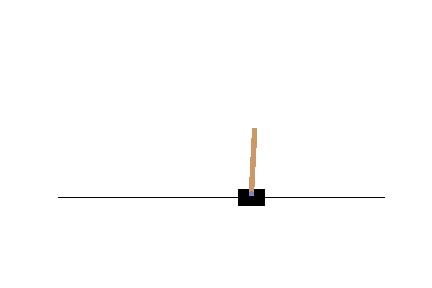
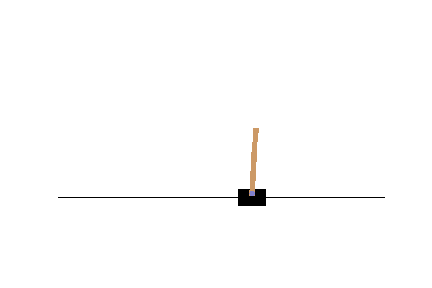
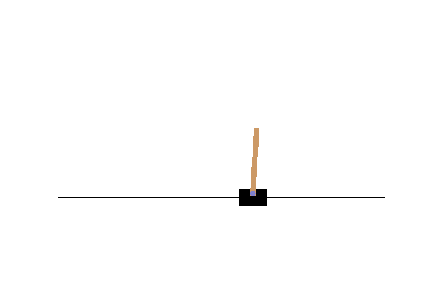
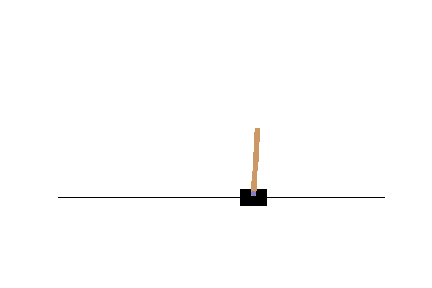
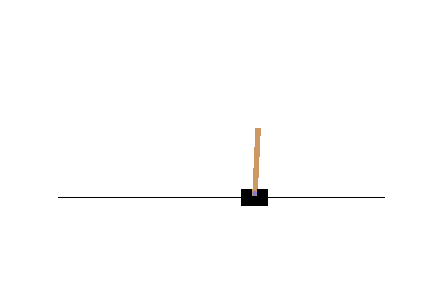
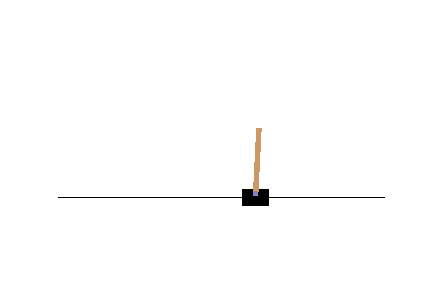
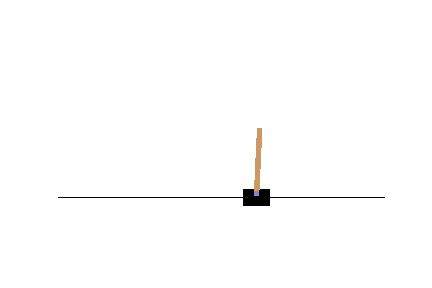
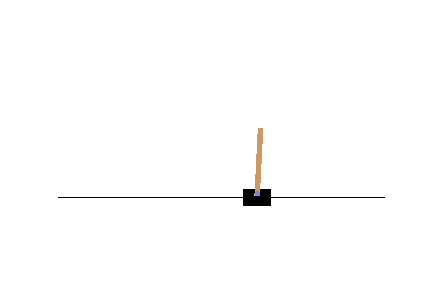
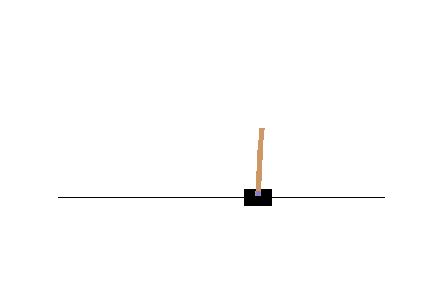
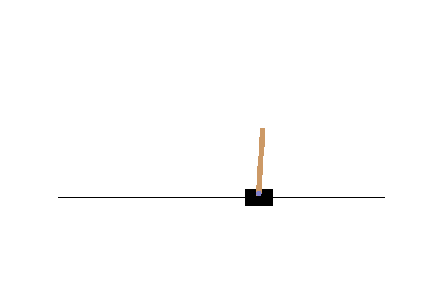
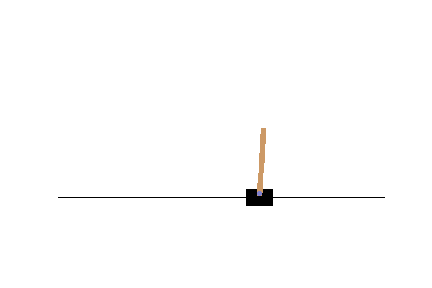
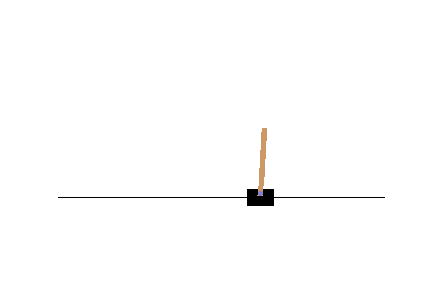
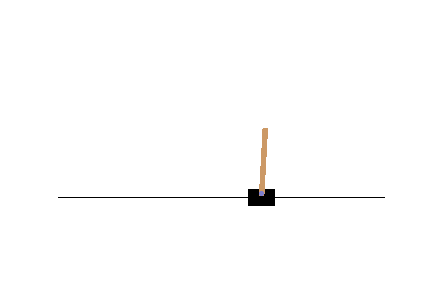
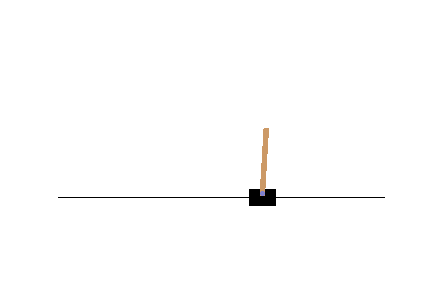
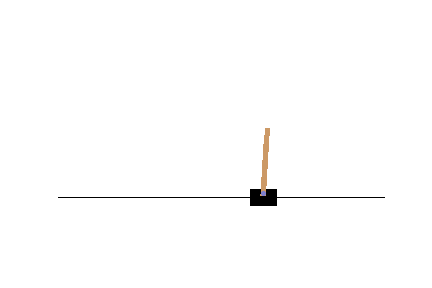
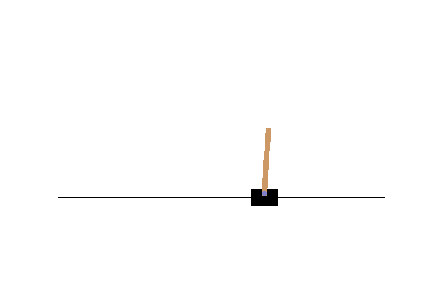
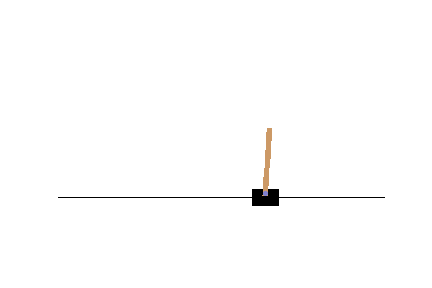
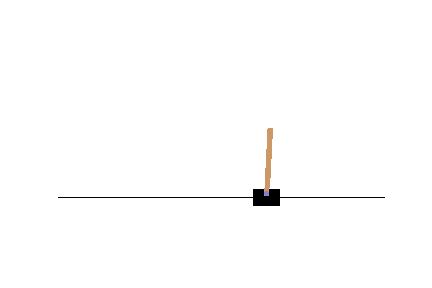
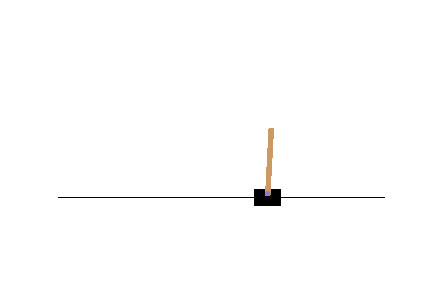
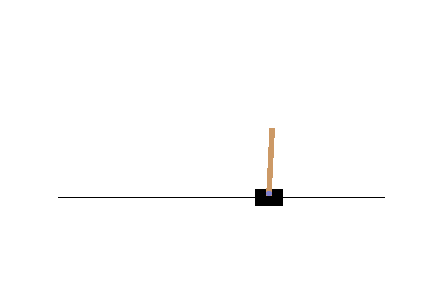
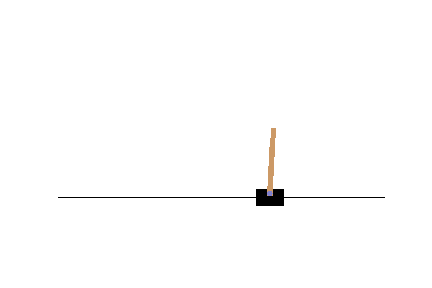
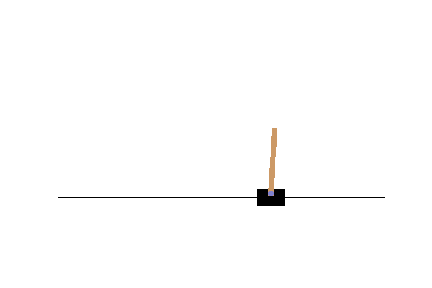
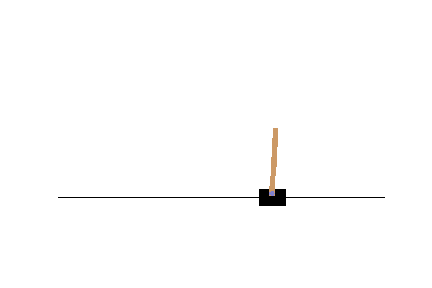
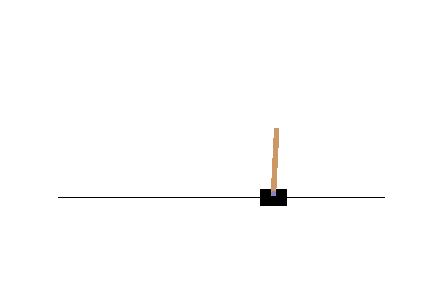
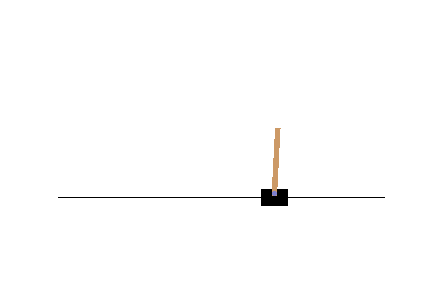
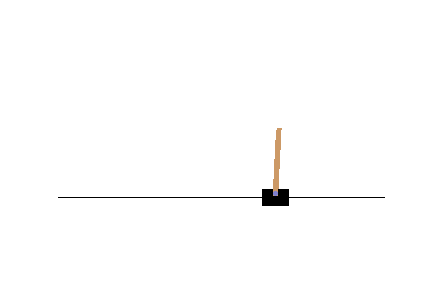
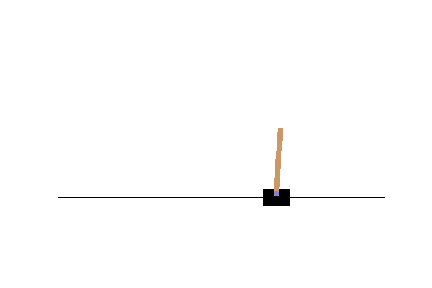
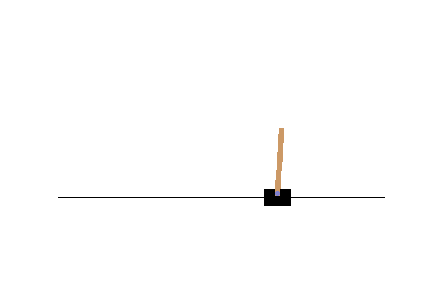
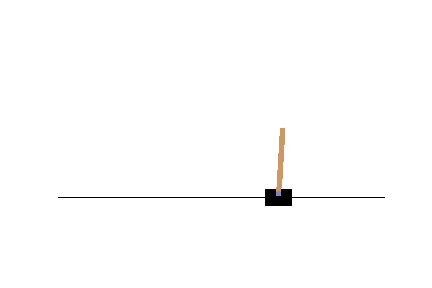
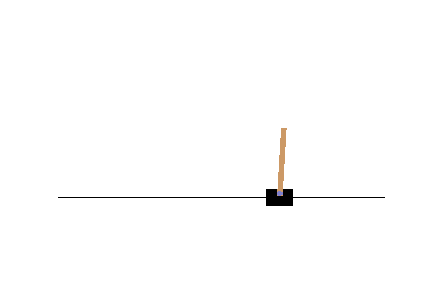
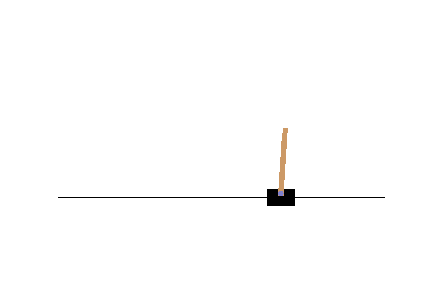
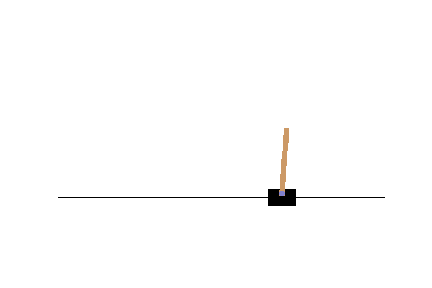
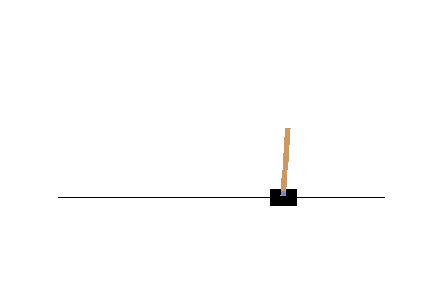
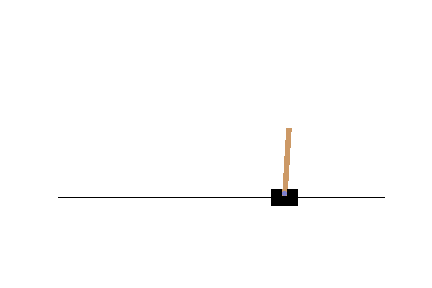
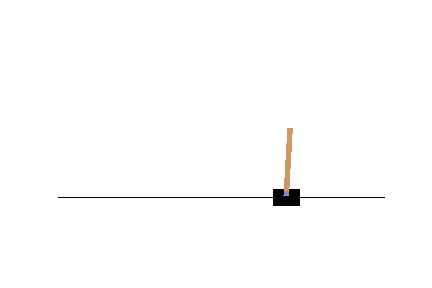
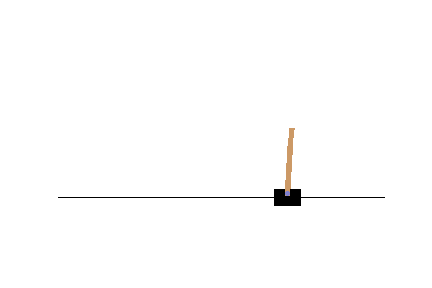
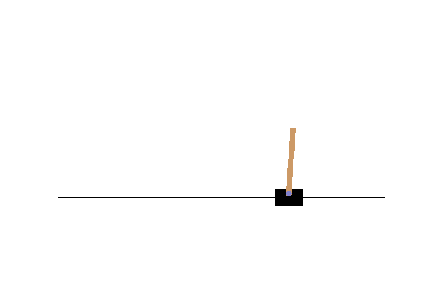
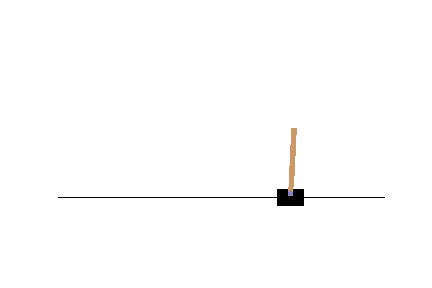
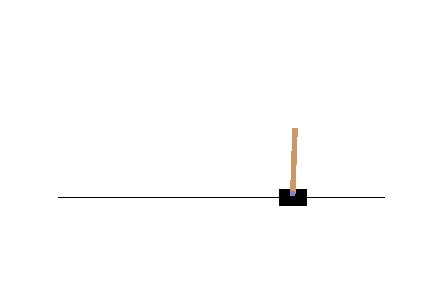
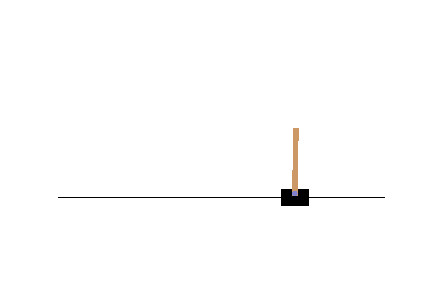
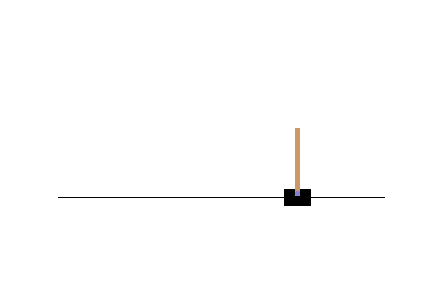
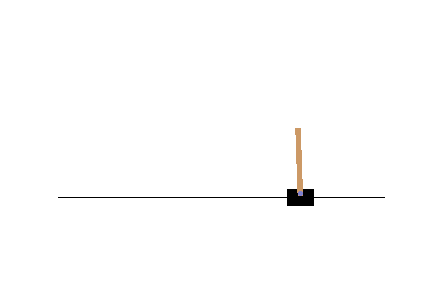
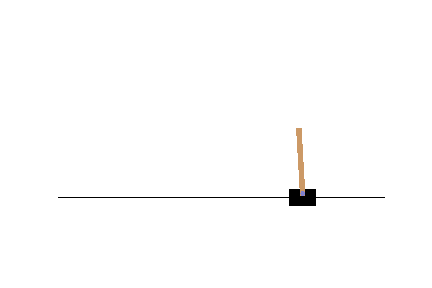
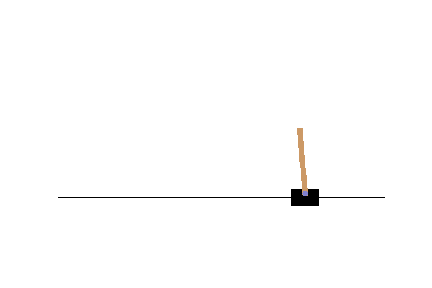
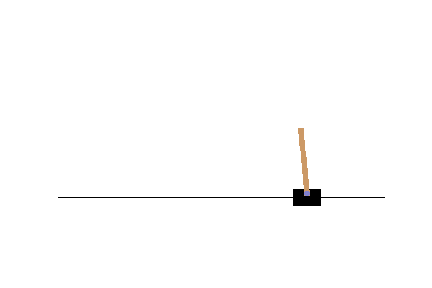
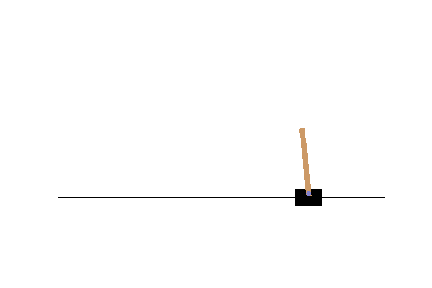
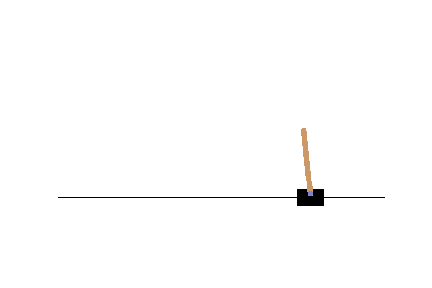
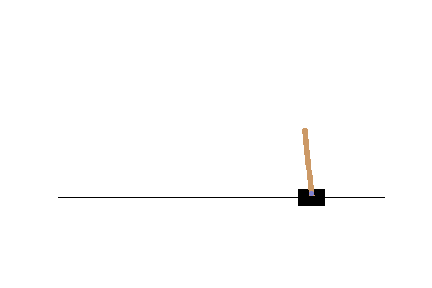
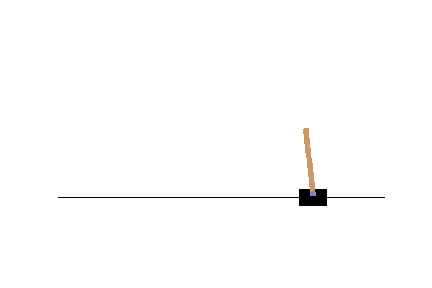
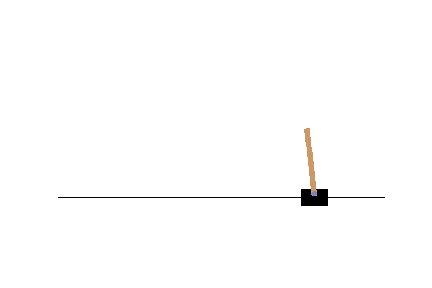
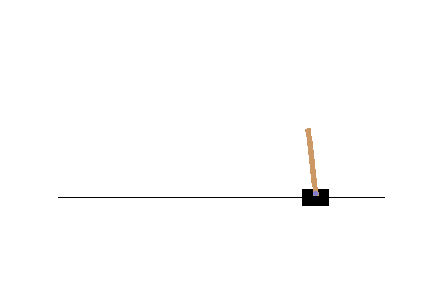
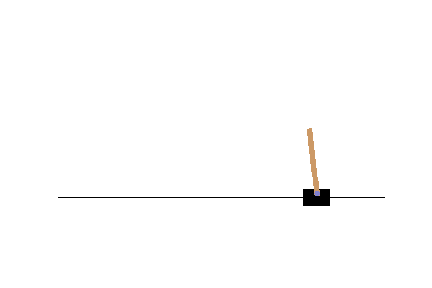
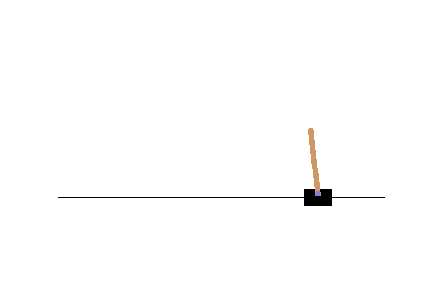
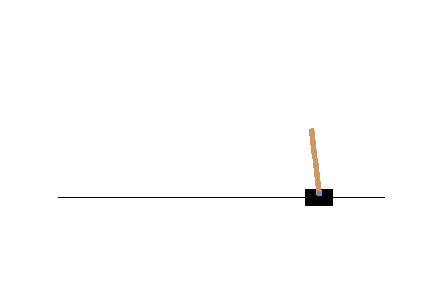

In [8]:
observation = env.reset()

frames = []
for _ in range(num_max_step):
    state = learn.digitize_state(env, observation, num_dizitized)
    action = learning.get_action(state, episode)
    observation, reward, done, info =  env.step(action)
    frames.append(env.render(mode = 'rgb_array'))
    if done:
        break
        
disp.display_frames_as_gif(frames)

## 学習曲線

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


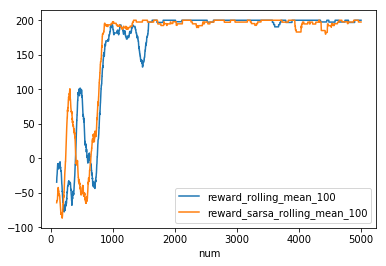

In [25]:
 # エピソード毎の獲得報酬を移動平均線で表示
df_rewards = pd.DataFrame({'num': range(0, len(rewards_sarsa)), 'reward': rewards, 'reward_sarsa': rewards_sarsa})
df_rewards['reward_rolling_mean_100'] = df_rewards['reward'].rolling(window=100,center=False).mean()
df_rewards['reward_sarsa_rolling_mean_100'] = df_rewards['reward_sarsa'].rolling(window=100,center=False).mean()
df_rewards.plot(kind='line', x='num', y=['reward_rolling_mean_100', 'reward_sarsa_rolling_mean_100'])